# Chapter 7 - Ulysses' Compass

- The Copernican model (heliocentric) wasn't particularly more accurate that the Ptolemaic (geocentric) model
    - Required slightly fewer epicycles
    - One argument was that it was conceptually simpler
- We often prefer simpler models to more complex ones
- **Ockham's Razor**: models with fewer parameters are to be preferred
- This chapter is about making the tradeoff between accuracy and simplicity
- Instead of Ockham's Razor, think of **Ulysses' Compass**. He had to thread the narrow path between Scylla and Charybdis, not passing too close to either
- In our case:
    - Overfitting, which leads to poor prediction by learning too much from the data
    - Underfitting, which leads to poor prediction by learning too little from the data
- Another issue, confounding, has been covered in previous chapters.

Two common families of approaches:
1. Regularization prior: tells the model not to get too excited by the data. ALso called "penalized likelihood".
1. Scoring device like **Information criteria** or **cross-validation** to model the prediction task and estimate predictive accuracy

Both approaches are regularly used and are sometimes used in combination.

To use the information criteria we first need to know a bit about **information theory**.

## The problem with parameters

In the **previous chapter**, we saw that adding parameters to a model can be dangerous - lots of bias can creep in. However, the models that we constructed were just fine at making prediction - they just didn't line up with the causes. So, if all you care about is making predictions can you just throw parameters in willy nilly?

No!

Adding parameters almost always increases the *fit* of the data. *Fit* is some measure of how well the model can rerodict the data used to fit it. There are a bunch - the most popular in linear models (probably due to its simplicity) is $R^2$ (also known as "variance explained"):

$$
R^2 = \frac{\text{var(\text{outcome}) - \text{var}(\text{residuals})}}{\text{var}(\text{outcome})} = 1 - \frac{\text{var}(\text{residuals})}{\text{var}(\text{outcome})}
$$

This measure increases as you add parameters to a model, even if the parameters are completely random and have no relation to the actual model. This means that measuring a model solely on fit is not a great idea.

While adding parameters to a model usually increases the fit on existing data, they often *decrease* the fit to new data. Models with many parameters tend to **overfit** the data. On the other hand, models with too few parameters tend to **underfit**, systematically under- or over-fitting new data even when it looks like the data used to construct the model.

### More parameters (almost) always improves fit

**Overfitting** occurs when a model learns too much from a sample. In every sample, there are both *regular* and *irregular* features. The regular ones are what we want to learn about, while the irregular ones don't generalize and so can mislead us.

Example of overfitting:

In [80]:
library('ggplot2')
library('rethinking')
library('dagitty')

In [9]:
sppname <- c("afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens")
brainvolcc <- c(438, 452, 612, 521, 752, 871, 1350)
masskg <- c(37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5)
d <- data.frame(species=sppname, brain=brainvolcc, mass=masskg)

Brain size and mass are expected to be correlated. We can ask: after you control for the mass, what other variation is there in brain size? This is a pretty common approach.

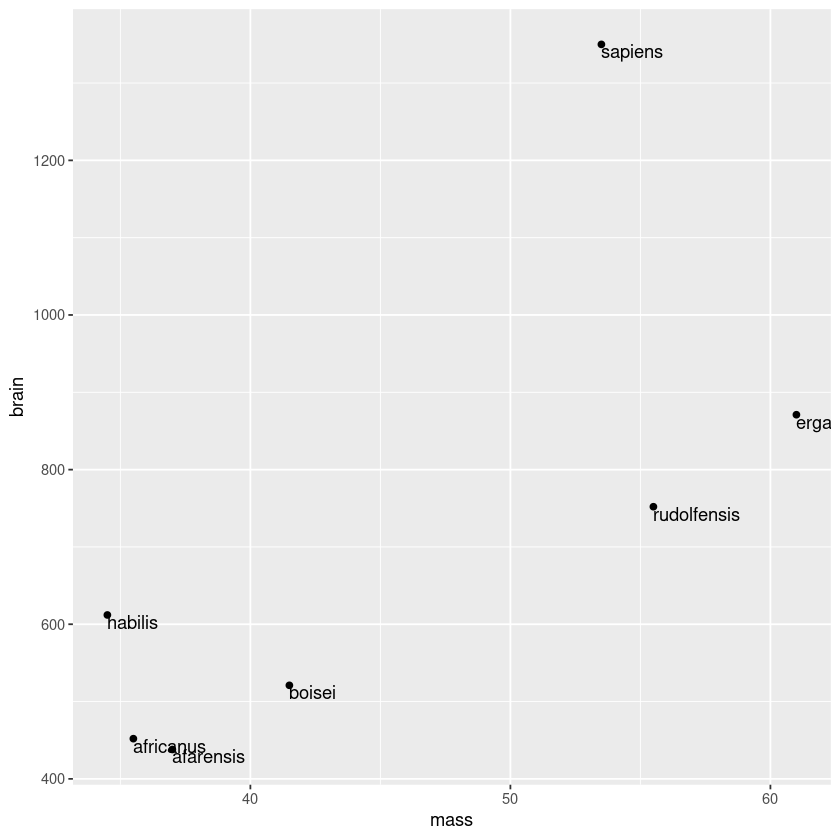

In [10]:
ggplot(d, aes(mass, brain, label=species)) +
    geom_point() +
    geom_text(hjust=0, vjust=1)

Obvious question - why a linear relationship between mass and body size? Most people would probably prefer to model this as the log of mass and the log of brain volume. But why not  cubic?

Let's fit a series of more and more complex models to this data and see what happens.

(First we standardize te data)

In [11]:
d$mass_std <- ( d$mass - mean(d$mass) ) / sd(d$mass)
d$brain_std <- d$brain / mean(d$brain) # doing it this way to preserve 0 as no brain

$$
\begin{align*}
b_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta m_i \\
\alpha &\sim \text{Normal}(0.5, 1) \\
\beta &\sim \text{Normal}(0, 10) \\
\sigma &\sim \text{Log-Normal}(0, 1) \\
\end{align*}
$$

Note that these priors are absurd - they allow for clearly nonsensical values like negative brains. That's ok though - it's part of the lesson.

In [12]:
m7.1 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b * mass_std,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d
)

Before moving on, let's compute the $R^2$.

We need to calculate the predictions the model makes, then subtract that from the actual values to get the residuals. Then we compute the variance of the data and the residuals. Note that we can't use the `var` function because in R that one uses the wrong denominator, so we will calculate it by hand.

In [13]:
set.seed(12)
s <- sim(m7.1)
r <- apply(s, 2, mean) - d$brain_std
resid_var <- var2(r)
outcome_var <- var2(d$brain_std)
1 - resid_var / outcome_var

[1] 0.478156

In [14]:
# as a function
R2_is_bad <- function(quap_fit) {
    s <- sim(quap_fit, refresh=0)
    r <- apply(s, 2, mean) - d$brain_std
    1 - var2(r) / var2(d$brain_std)
}

Now we'll consider a bunch more models, each a polynomial of higher degree. To do this using `quap`, we define $\beta$ as a vector. The trick is to tell `quap` how long the list is by using a `start` list:

In [15]:
m7.2 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d,
    start=list(b=rep(0,2))
)

m7.3 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2 + b[3] * mass_std ^ 3,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d,
    start=list(b=rep(0,3))
)

m7.4 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2 + b[3] * mass_std ^ 3 + b[4] * mass_std ^ 4,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d,
    start=list(b=rep(0,4))
)

m7.5 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2 + b[3] * mass_std ^ 3 + b[4] * mass_std ^ 4 + b[5] * mass_std ^ 5,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d,
    start=list(b=rep(0,5))
)

m7.6 <- quap(
    alist(
        brain_std ~ dnorm(mu, exp(log_sigma)),
        mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2 + b[3] * mass_std ^ 3 + b[4] * mass_std ^ 4 + b[5] * mass_std ^ 5 + b[6] * mass_std ^ 6,
        a ~ dnorm(0.5, 1),
        b ~ dnorm(0, 10),
        log_sigma ~ dnorm(0, 1)
    ),
    data=d,
    start=list(b=rep(0,6))
)

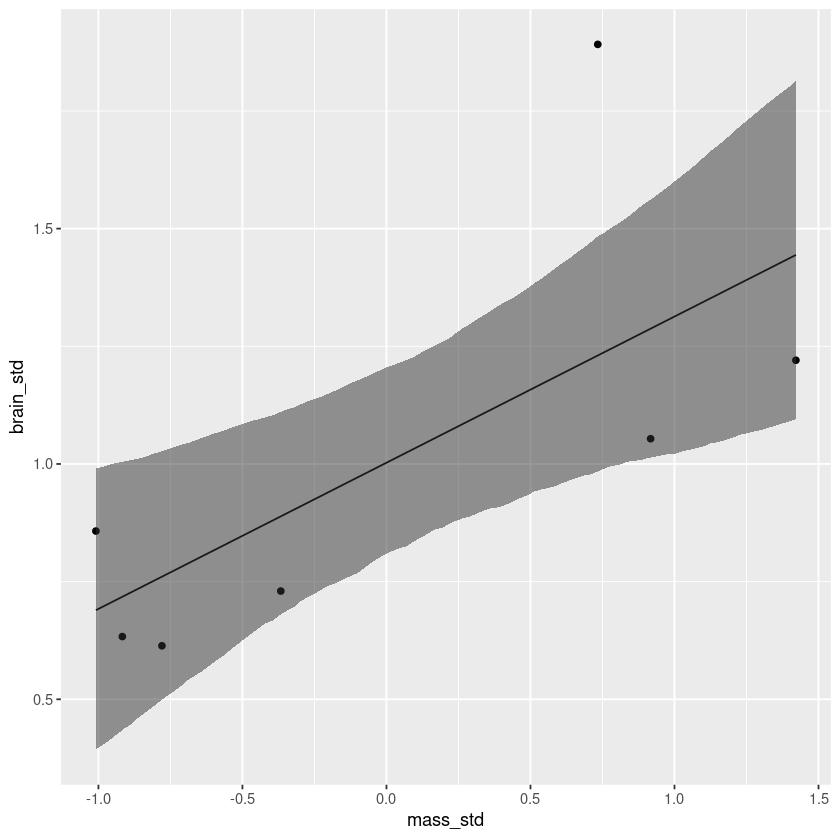

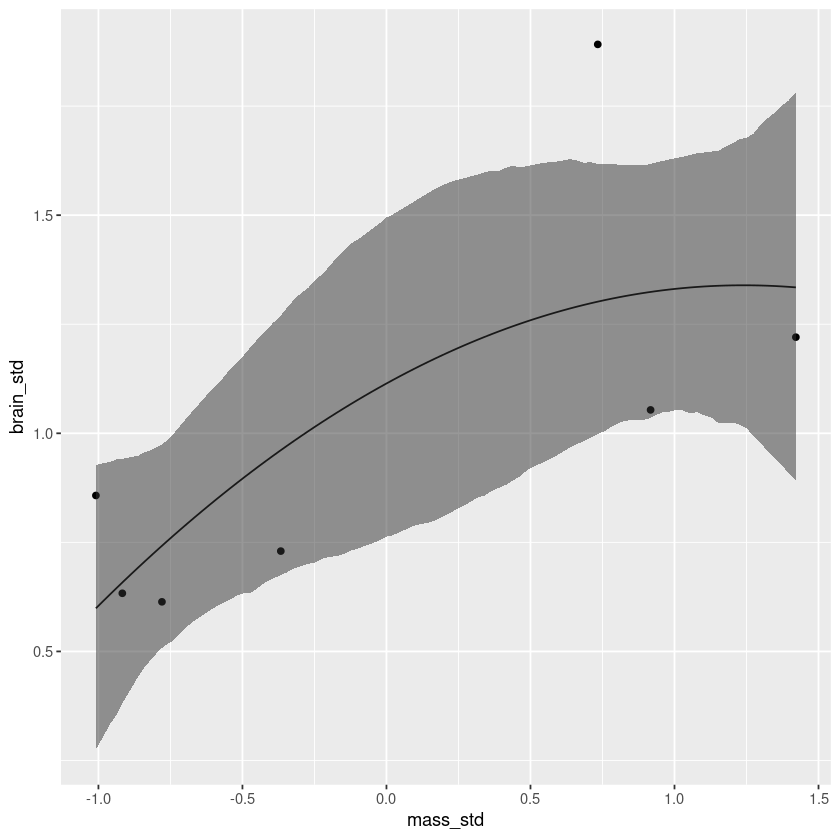

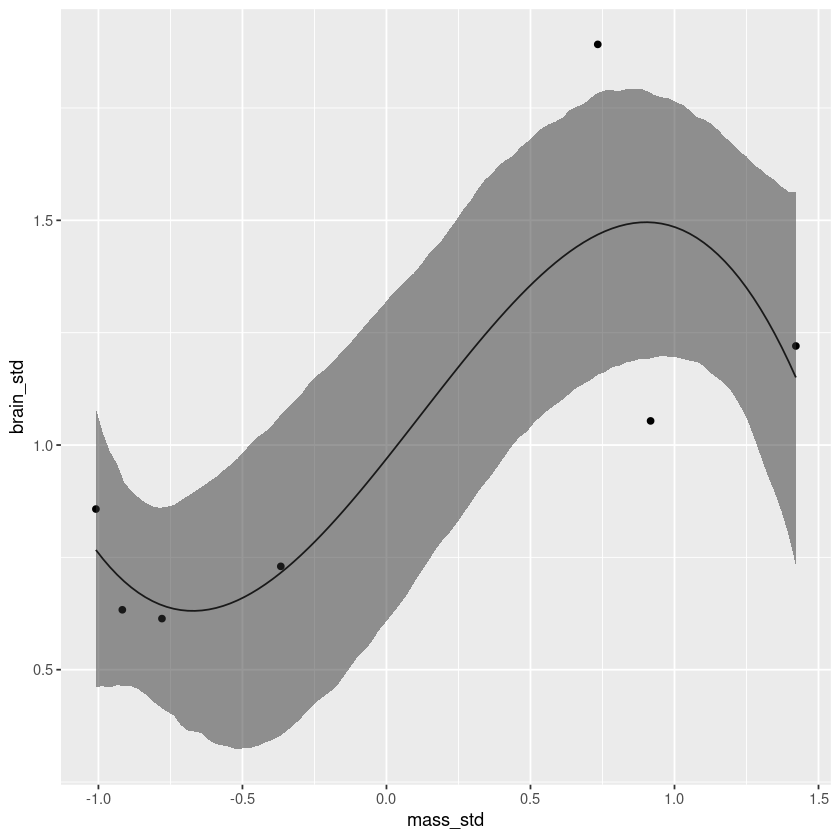

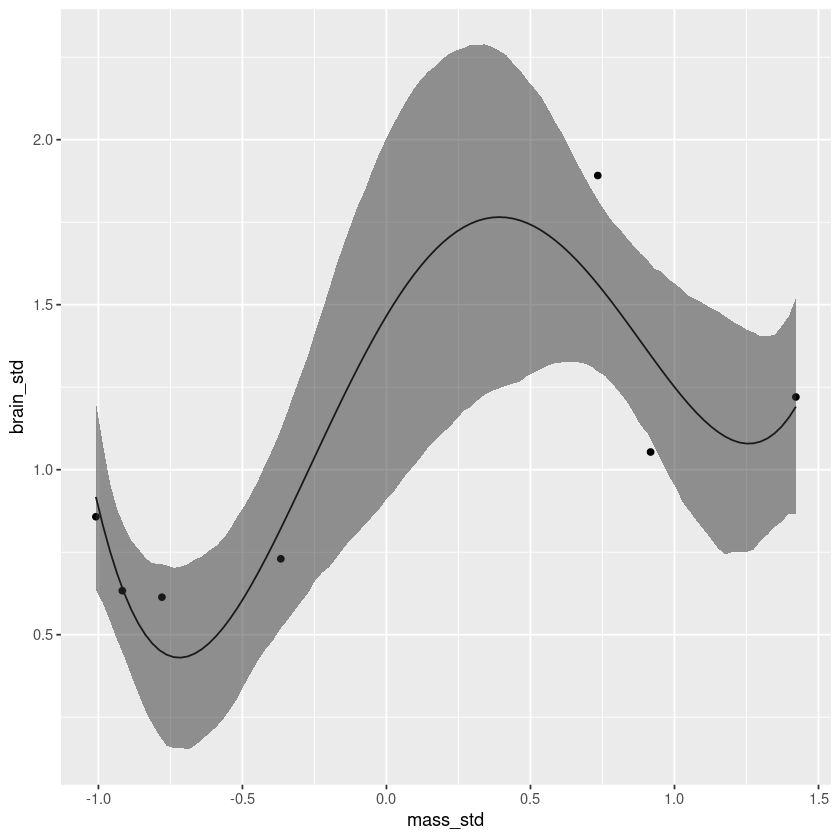

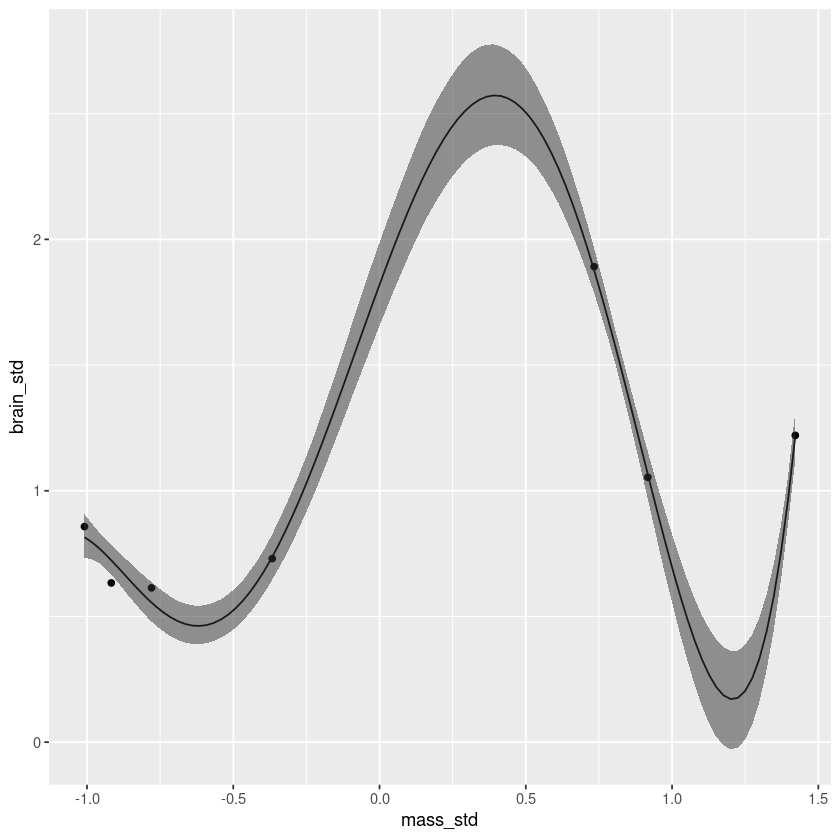

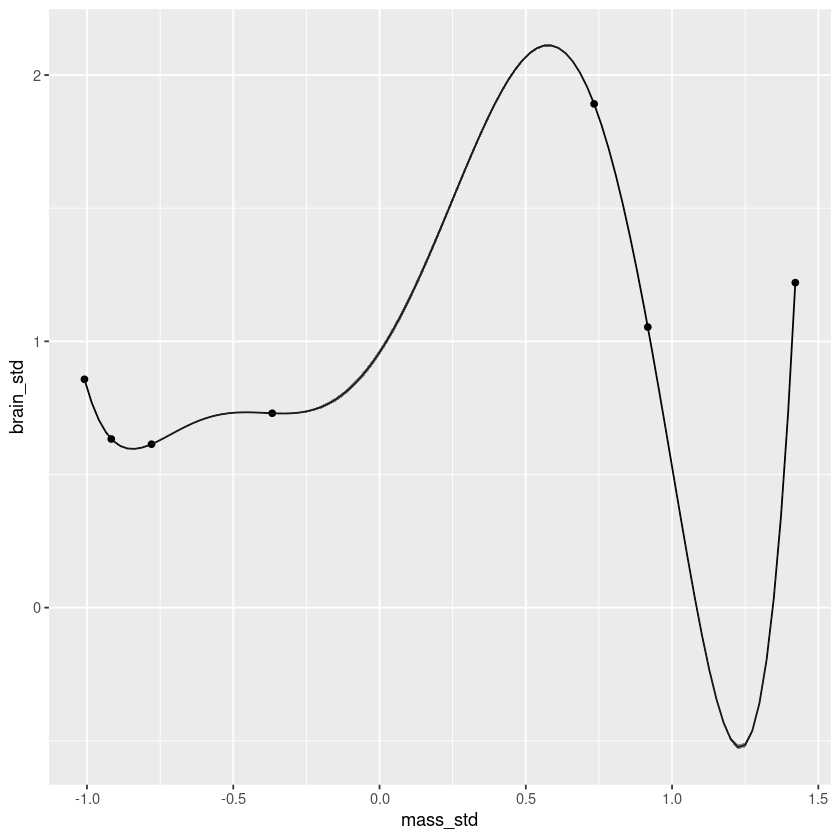

In [16]:
models <- c(m7.1, m7.2, m7.3, m7.4, m7.5, m7.6)
for (model in models) {
    post <- extract.samples(model)
    mass_seq <- seq(from=min(d$mass_std), to=max(d$mass_std), length.out=100)
    l <- link(model, data=list(mass_std=mass_seq))
    mu <- apply(l, 2, mean)
    ci <- apply(l, 2, PI)
    plot_df <- data.frame(
        mass=mass_seq,
        mu=mu,
        lower=ci[1,],
        upper=ci[2,]
    )

    plot <- ggplot() +
        geom_point(data=d, mapping=aes(mass_std, brain_std)) +
        geom_line(data=plot_df, mapping=aes(mass, mu)) +
        geom_ribbon(data=plot_df, mapping=aes(mass, mu, ymin=lower, ymax=upper), alpha=0.5)
    print(plot)
}

In each case, the complexity of the model increases, and so does the $R^2$ value. In the last case, the model goes perfectly through every point: $R^2 = 1$, depite it being a patently absurd model.

### Too few parameters hurts, too

Too many parameters is obviously bad - they produce models which fit the data extremely well, but fail on out-of-sample data. Underfitting, on the other hand, produces models that fail for both in- and out-of-sample data.

One way to conceptualize this is that the underfit model is not sensitive to the data. If we remove one point from the sample, the linear model will hardly change at all. On the other hand, the degree 6 model will change wildly!

In [17]:
plot_df <- data.frame(
    mu=double(),
    mu=double(),
    id=factor(),
    model=factor()
)
for (i in 1:nrow(d)) {
    d_minus_i <- d[-i,]
    m7.1_without <- quap(
        alist(
            brain_std ~ dnorm(mu, exp(log_sigma)),
            mu <- a + b * mass_std,
            a ~ dnorm(0.5, 1),
            b ~ dnorm(0, 10),
            log_sigma ~ dnorm(0, 1)
        ),
        data=d_minus_i
    )
    m7.4_without <- quap(
        alist(
            brain_std ~ dnorm(mu, exp(log_sigma)),
            mu <- a + b[1] * mass_std + b[2] * mass_std ^ 2 + b[3] * mass_std ^ 3 + b[4] * mass_std ^ 4,
            a ~ dnorm(0.5, 1),
            b ~ dnorm(0, 10),
            log_sigma ~ dnorm(0, 1)
        ),
        data=d_minus_i,
        start=list(b=rep(0,4))
    )
    models <- c(m7.1_without, m7.4_without)
    j <- 0
    for (model in models) {
        j <- j + 1
        post <- extract.samples(model)
        mass_seq <- seq(from=min(d$mass_std), to=max(d$mass_std), length.out=100)
        l <- link(model, data=list(mass_std=mass_seq))
        mu <- apply(l, 2, mean)
        to_add <- data.frame(
            mass=mass_seq,
            mu=mu,
            id=as.factor(i),
            model=as.factor(j)
        )
        plot_df <- rbind(plot_df, to_add)
    }
}

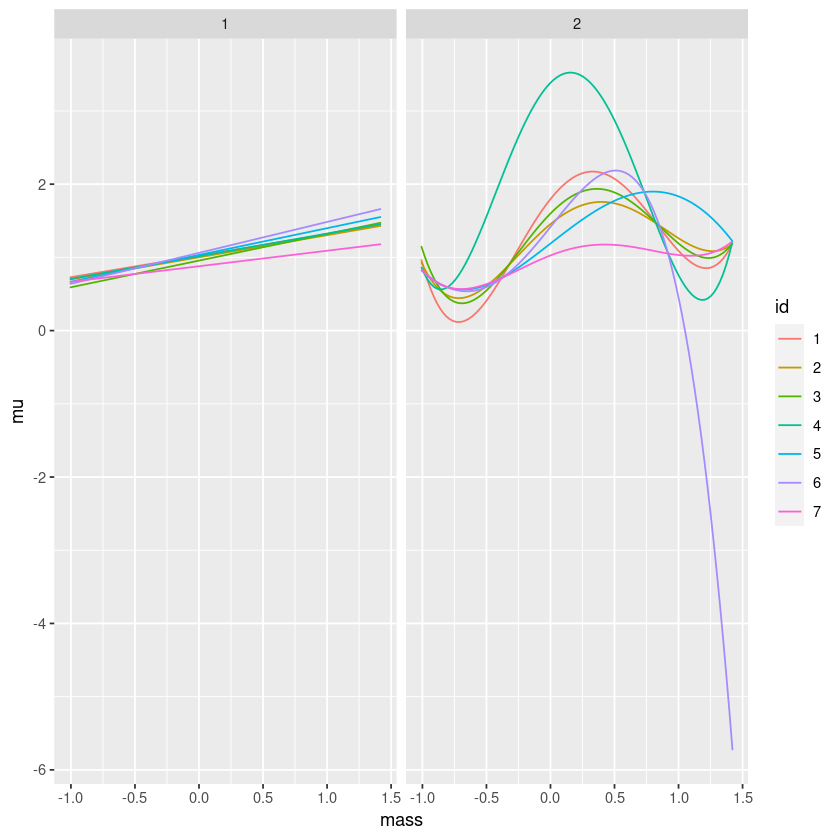

In [18]:
ggplot(plot_df, aes(mass, mu, colour=id)) + 
    geom_line() +
    facet_wrap(vars(model))

As you can see, even for the degree 4 model, dropping a single row of data has a dramatic effect on the data, while the linear model doesn't change very much at all!

## Entropy and Accuracy

Before we can figure out the tradeoff between over and underfitting, we need to set a *target* - how will we know our model is a good model?

1. Establish a measurement scale for distance from perfect accuracy (will require some information theory)
1. Need to establish *deviance* as an approximation of relative distance from perfect accuracy
1. Establish that only deviance out-of-sample is relevant

### Firing the weatherperson

Accuracy depends on the definition of the target, and there is no universal "best target". Two major dimensions to worry about:
1. *Cost-benefit analysis* How much does it cost when were wrong? How much do we win when we're right?
1. *Accuracy in context* Some prediction tasks are inherently easier than others; we need a way to judge accuracy that accounts for how much a model can possibly improve prediction.

Say we have  weatherperson issues predictions in the form of probability of rain each day.

|  Day        | 1 | 2 | 3 |  4  | 5   | 6  | 7 | 8 | 9 | 10 |
|---          |---|---|---|---  | --- |--- |---|---|---|--- |
| Prediction  | 1 | 1 | 1 | 0.6 | 0.6 | 0.6|0.6|0.6|0.6|0.6|
| Observed    | R | R | R | S   | S   | S  | S | S | S | S |

A new person comes to town and boasts that he can beat the current weatherperson by just always predicting sun:

|  Day        | 1 | 2 | 3 |  4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---          |---|---|---|--- |---|---|---|---|---|--- |
| Prediction  | 0 | 0 | 0 | 0  | 0 | 0 | 0 | 0 | 0 | 0 |
| Observed    | R | R | R | S  | S | S | S | S | S | S |

The newcomer is right - if the hit rate if the average chance of a correct prediction, then the old person gets $3 \times 1 + 7 * 0.4 = 5.8$, which over 10 days is $5.8 / 10 = 0.58$, while the newcomer gets $(3 * 0 + 7 * 1) / 10 = 0.7$ - they clearly win.

#### Costs and benefits

Let's consider costs and benefits. say you hate getting caught in the rain (-5), but also dislike carrying an umbrella (-1). Say your chance of carrying an umbrella is equal to the probability of rain. Then here is what that looks like.

|  Day        | 1 | 2 | 3 |  4  | 5   | 6  | 7 | 8 | 9 | 10 |
|---          |---|---|---|---  | --- |--- |---|---|---|--- |
| Observed    | R | R | R | S   | S   | S  | S | S | S | S |
|---          |---|---|---|---  | --- |--- |---|---|---|---|
|Current      |-1 |-1 |-1 |-0.6 |-0.6 |-0.6|-0.6|-0.6|-0.6|-0.6|
|Newcomer     |-5 |-5 |-5 | 0   |   0 | 0  | 0 | 0 | 0 | 0 |

In this case, the current weatherperson nets you -7.2 happiness, while the newcomer nets you -15.

#### Measuring Accuracy

Even if we ignore costs and benefits, we still need to consider what we mean by 'accuracy'. There's nothing special about the hit rate. Question: which measure of accuracy is maximized if we *know* the true model generating the data?

Consider computing the probability of predicting the exact sequence of days. This means predicting the correct probability for each day, and multiply these all together to get the joint probability for all the days. This is the same thing as the joint likelihood!

In this light, the newcomer is worse. The probability for the current weatherperson is $1^3 \ast 0.4 ^ 7 \approx 0.005$. For the newcomer, it's $0^3 \ast 1 ^ 7 = 0$. The newcomer has 0% chance of getting the sequence right.

It turns out that it's this joint probability that we want. Why? It appears in Bayes' Theorem as the likelihood.Unique measure that correctly counts up the relative number of ways each event (sequence of rain and shine) coud happen. The true model will have the highest joint probability.

In the literature, this is called the **log scoring rule**, because typically you compute the log of the joint probability and report that.

---
Calibration is overrated

Common for models to be measured by their calibration - this is, if they predict a 40% chance of rain, a model is "calibrated" if it rains 40% of the time.

However, calibrated models don't have to be good. For instance, if it rains 40% of the time then you can always give that prediction, regardless of the probabilities on the actual day. This will result in good calibration but otherwise poor performance. Conversely, a highly accurate model doesn't have to be well-calibrated.

---

### Information and uncertainty

We want to use the log probability of the data to score the accuracy of competing models. The next problem - how do we measure distance from the prediction? A perfect prediction would give exactly the probability of rain, and so we could measure the distance between their prediction and the 'true' one. But what kind of distance?

Turns out that there's a unique answer!

What should an accuracy metric do?

Appreciate that some targets are easier to hit than others - predicting weather in the winter (sun, cloud, snow) is harder than the summer (only sun and cloud).

Answer comes from **Information Theory**. Basic insight is to ask: *how much is our uncertainty reduced by learning an outcome?*

Consider the weather forecast again. Forecasts are issued in advance, when the weather is uncertain. When the day arrives, the weather is no longer uncertain. The reduction in uncertainty is then a natural measure of how much we've learnt. The measured decrease in uncertainty ist he definition of *information*, in this context.

To use this definition, we'll need a way to quantify the uncertainty inherent in a probability distribution. So, say there are two possible outcomes: rain and sun, and they occur with some probability. We want a function that uses the probabilities of rain / sun to produce a measure of uncertainty.

Three things we want:
1. Measure of uncertainty should be continuous
1. Should increase as the number of possible events increases
1. Should be additive. That is, if we first compute the measure over rain / sun, and then separately over temperature (hot / cold), the uncertainty over the combination of these should be the sum of the original measures.

There is exactly one function that satisfies these: the **Information Entropy**. Consider $n$ outcomes, each with $p_i$ of occurring, then 

$$
H(p) = -E \log (p_i) = -\sum_{i=1}^n p_i \log(p_i)
$$

In other words:

The uncertainty contained in a probability distribution is the average log-probability of an event.

As an example: say that the true probability or rain and shine are $p_1 = 0.3$ and $p_2 = 0.7$. Then 

$$
H(p) = -(p_1 \log p_1 + p_2 \log p_2) \approx 0.61
$$

In [19]:
p <- c(0.3, 0.7)
-sum(p * log(p))

[1] 0.6108643

Now say we live in Abu Dhabi, where the probabilities might be more like $p_1 = 0.01$ and $p_2 = 0.99$. Then the entropy is much lower - 0.06. There's a lot less uncertainty about the weather if it is sunny almost all the time. 

---

There's something tricky about the definition - what if $p_i = 0$? We can use L'Hopital's Rule to show that $\lim_{p \to 0}p\log p =0$, so we can safely ignore it. Another way of stating this: there's no point including impossible events in our model.

---

---

Information theory has many applications. One important technique is **Maximum Entropy** (also know as Maxent). This is a family of techniques for finding probabiliy distributions that are most consistent with the data. In other words, given the data, what is the *least surprising* distribution? The one answer to this question maximizes the information entropy using the propr knowledge as a constraint. If you do this, you end up with the posterior distribution! Bayesian updating is entropy maximization. This will feature prominently in **Chapter 10**.

---

### From entropy to accuracy

$H$ provides a way to measure the uncertainty. But how can we use information entropy to say how far a prediction is from the target? Key is **Divergence**:

Divergence: the additional uncertainty induced by using probabilities from one distribution to describe another distribution.

This is often known as Kullback-Leibler Divergence or just KL Divergence.

For instance: say the true probabilities are $p_1=0.3$, $p_2=0.7$. If we instead believe that the true probabilities are $q_1=0.25$ and $q_2=0.75$, how much additional uncertainty have we introduced as a consequence of using $\{q_1, q_2\}$ instead of $\{p_1, p_2\}$?

The answer is based on $H$:

$$
D_{KL}(p, q) = \sum_i \left[ p_i(\log p_i 0 \log q_i)\right] = \sum_i p_i \log\left(\frac{p_i}{q_i}\right)
$$

in plainer language: it's the average different in log probabilities between the target $p$ and the model $q$. This divergence is the difference between the two entropies: the entropy of the target distribution $p$ and the **cross entropy** arising from using $q$ to predict $p$. When $p=q$, we know the true probabilities and so

$$
D_{KL}(p, q) = D_{KL}(p, p) = \sum_i \left[ p_i(\log p_i 0 \log p_i)\right] = 0
$$

There is no additional uncertainy introduced when using a distribution to model itself.

As $q$ becomes more different from $p$, the divergence $D_{KL}$ grows. Say $p = \{0.3, 0.7\}$. Then for a wide variety of $q[1]$, here is what that looks like

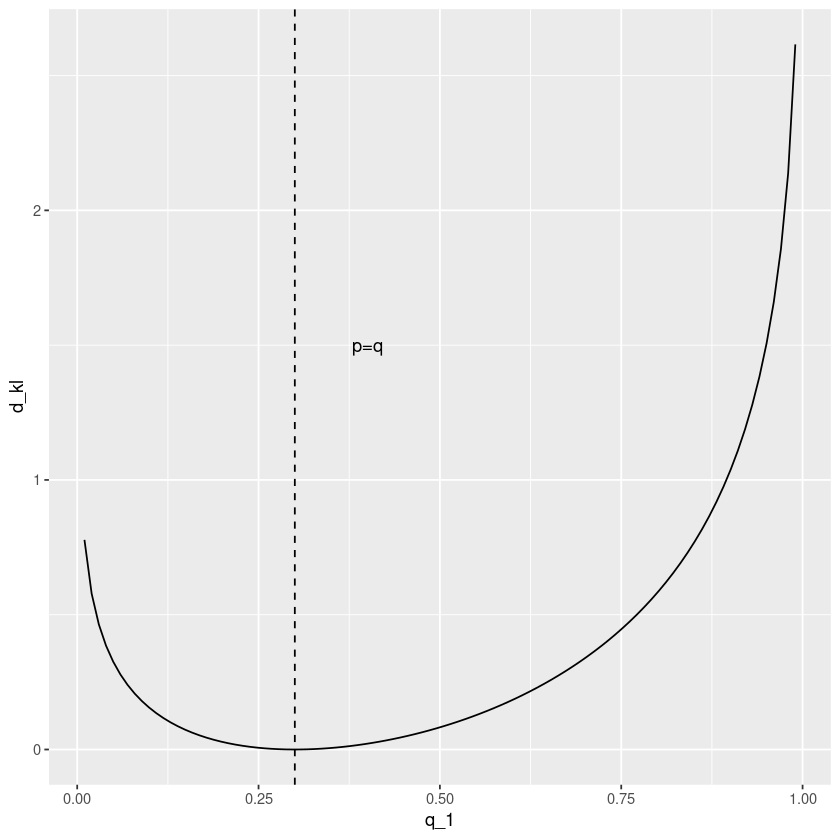

In [20]:
d_kl <- function(p, q) {
    return(sum(p * log(p / q)))
}

q_1 = seq(0.01, 0.99, length.out=100)
plot_df <- data.frame(q_1=double(), d_kl=double())
for (q_1 in seq(0.01, 0.99, length.out=100)) {
    to_add <- data.frame(
        q_1=q_1,
        d_kl=d_kl(p, c(q_1, 1-q_1))
    )
    plot_df <- rbind(plot_df, to_add)
}
ggplot(plot_df, aes(q_1, d_kl)) +
    geom_line() +
    geom_vline(xintercept=p[1], linetype='dashed') +
    annotate("text", x=0.4, y=1.5, label="p=q")

So now we have a way of comparing models - using the divergence!

---

Cross entropy: the entropy from using a probability distribution $q$ to predict a distribution $p$: $H(p, q) = -\sum_i p_i \log q_i$.

(Note: the information entropy (and hence the divergence) are not symmetrical! $H(p, q)$ is not usually equal to $H(q, p)$.)

---

### Estimating divergence

Recall that the original goal was to deal with underfitting or overfitting of models. We needed two pieces to do that:
1. How to measure the distance of a model from the target. We now have that, in the form of the **KL Divergence**
1. How to estimate the divergence

For the second one, we'll use the divergence to get to the **Deviance**.

Naively, to compare models using the KL divergence, we would need to know the true. However, it turns out that we really don't! Say we have two models for $p$: $q$ and $r$. Then we want to know which one is closest to $p$. Since there is an $E \log p_i$ term in both, they end up subtracting out, leaving us with basically just the model components! Then what we really need is the sum of the log probabilities for each model: $E \log q_i$ and $E \log r_i$.

We can compute the average log-probability from each model to get an estimate of the distance to the target. Note that the actual magnitude isn't really interpretable - we can't use it to say that one model is "good" or "bad". Only the difference, $E\log q_i - E\log r_i$ tells us about the divergence of each model from $p$.

Conventionally, we sum over all the observations $i$, yielding a model score

$$
S(q) = \sum_i \log q_i
$$

(This is an estimate of $E\log q_i$), but without dividing by $n$ at the end)

To compute the score for a Bayesian model, we sum over the entire distribution. Apparently there's some subtlety here, so there's a function, `lppd` (Log-Pointwise Predictive-Density) to do it for `quap` models.

In [21]:
set.seed(1)
lppd(m7.1, n=1e4)

[1]  0.02242293  0.06376169 -0.05411452  0.03429193 -0.13170494 -0.15857809
[7] -1.60812082

Each of these is the score for each data point (recall: there were only 7). For this, larger values are generally better. Sometimes you'll see the **Deviance** instead - that's the same thing, but multiply each value by -2 (for historical reasons) so that in that case, smaller values are better.

### Scoring the right data

The log-probability score is a principled way to measure the distance from a target. However, it has the same issue as $R^2$: it increases with the number of parameters.

In [22]:
set.seed(1)
sapply(list(m7.1, m7.2, m7.3, m7.4, m7.5, m7.6), function(m) sum(lppd(m)))

[1] -1.8243938 -1.7344022 -0.5736935  1.0079625  9.9566168 39.4278779

We see that the score increases as the models become even more complex, even though we know that they're nonsense.

Before looking at tols to improve and easure out-of-sample scores, let's simulate the data both in and out of sample.

When we have data and use it to fit a statistical model, the data is the **training sample**. Parameters are estimated from it, and then we use those estimates to predict outcomes in a new sample, the **test sample**. Procedure:
1. Suppose there's a training sample of size $N$
1. Compute the posterior distribution of a model for the training sample and compute the score on the training sample - $D_{\text{train}}$
1. Suppose another sample of size $N$ from the same process - this is the test sample. Compute the score on the test sample, using the posterior trained on the training sample. Call this $D_{\text{test}}$

We'll now do this 10 000 times for each of the five different models.

The model that generates the data is

$$
\begin{align*}
    y_i &\sim \text{Normal}(\mu_i, 1) \\
    \mu_i &= 0.5 x_{ 1,i } -0.4 x_{2,i}
\end{align*}
$$

The models for analyzing the data are linear regressions with between 1 and 5 free parameters. The "true" model has non-zero $\beta$ only for the first two variables $\to$ it has three parameters.

In [23]:
N <- 20
kseq <- 1:5
dev <- sapply(kseq, function(k) {
    print(k);
    r <- replicate(1e2, sim_train_test(N=N, k=k));
    c(mean(r[1,]), mean( r[2,] ), sd(r[1,]), sd(r[2,]))
})

In [25]:
plot_df_in <- data.frame(num_params=1:5, dev=dev[1,], lower=dev[1,] - dev[3,], upper=dev[1,] + dev[3,], key="inner")
plot_df_out <- data.frame(num_params=1:5, dev=dev[2,], lower=dev[2,] - dev[4,], upper=dev[2,] + dev[4,], key="outer")
plot_df <- rbind(plot_df_in, plot_df_out)
ggplot(plot_df, aes(num_params, dev)) +
    geom_point(aes(colour=key)) +
    geom_errorbar(aes(ymin=lower, ymax=upper, colour=key))

ERROR: Error in data.frame(num_params = 1:5, dev = dev[1, ], lower = dev[1, ] - : object 'dev' not found


The above code takes forever to run, but basically the idea is that the deviance increases as the number of parameters increases - that is, the model shows evidence of overfitting.

Deviance is an assessment of predictive accuracy, not truth. For instance, the deviance for the 2-parameter model (the "true" one) is worse than for the 1-parameter one. This is a result of the additional inaccuracy from the estimate of the second parameter swamping the additional accuracy it should give.

## Golem Taming: regularization

One way to produce better predictions is to make the model worse at fitting the sample.

Basically, the idea is that if you give a model quite flat priors, it thinks that basically all values are plausible, and so the training data is given more weight in the posterior. One way to prevent this is to use a 'skeptical' prior - one that slows the rate of learning from the model. Most common type is a **regularization prior**. When tuned properly, it reduces overfitting while still allowing the model to learn from the data. If the prior is too skeptical, then regular features will be missed - important to tune it correctly.

In previous chapters, played with the priors until they were reasonable. Those priors *regularized* the results. Consider the following model:

$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta x_i \\
\alpha &\sim \text{Normal}(0, 100) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

Assume that $x$ has been standardized so that it has mean 0 and variance 1. Then $\alpha$ is a basically flat prior - it has almost no effect on inference. However, the prior on $\beta$ is narrower - it is meant to regularize. That prior indicates that before seeing the data, the model should be very skeptical of data below -2 or above 2. Since $x$ is standardized, we can interpret this as saying that it is very unlikely that a change of 1 sd in $x$ will produce as much as 2 sd change in $y$.

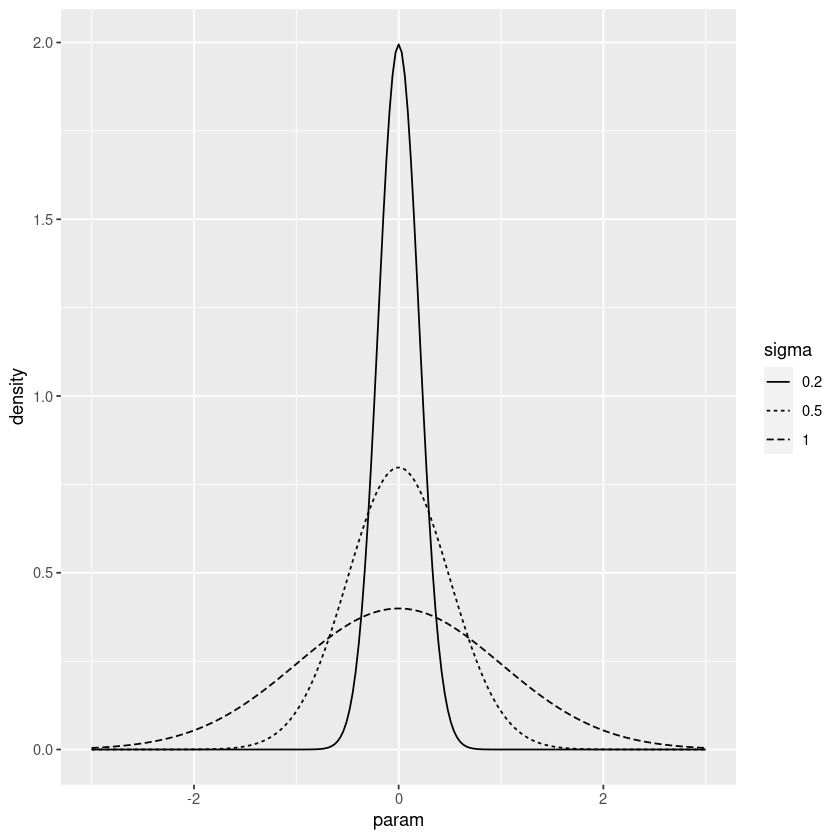

In [26]:
# some regularization priors
param_seq <- seq(-3, 3, length.out=201)
plot_df <- data.frame(param=double(), density=double(), sigma=double())
for (sigma in c(1, 0.5, 0.2)) {
    to_add <- data.frame(param=param_seq, density=dnorm(param_seq, 0, sigma), sigma=sigma)
    plot_df <- rbind(plot_df, to_add)
}
plot_df$sigma <- factor(plot_df$sigma)

ggplot(plot_df, aes(param, density)) +
    geom_line(aes(linetype=sigma))

Again, you can look at the test / train with the different priors. The training deviance increases (gets worse) with tighter priors - it doesn't learn as much from the data. However, the out-of-sample improves (gets smaller) with tighter priors. Note also that the overfitting for models with too many parameters is greatly reduce with a strong regularizing prior - the deviance for the models with 4 or 5 parameters is barely worse than that for the correct 3-parameter model when using the $\sigma=0.2$ model.

## Predicting predictive accuracy

So the above suggests one way to solve the overfitting / underfitting problem: evaluate the models out-of-sample. Issue: we generally don't have out-of-sample data, so how can we evaluate the model on it? Two main ways:
1. **Cross-Validation**
1. **Information Criteria**

Both of these try to predict how well models will perform in predicting new data. They both produce generally similar results.

### Cross-validation

Popular strategy is to actually test the accuracy on another sample. This is known as *cross-validation* - leaving out a small chunk of observations from the sample and evaluating the model on those.

Generally, we don't want to leave out data, so what we do instead is to divide the sample into a number of chunks, called *folds*. The models is asked to predict each fold, after being trained on the others, and we average the score for each fold to get an estimate of out-of-sample accuracy. Minimum number of folds is 2.

The `cv_quap` function in `rethinking` can perform cross-validation on `quap` models.

How many folds should you use? Apparently there's not a lot of study into this question. It's common to use the maximum number of folds, resulting in leaving out exactly one observation from each fold. This is called **Leave-One-Out Cross-Validation** (LOOCV). This is what we'll consider in this chapter and it is the default in `cv_quap`.

Key problem: if you have 1000 data points, then you'll end up with 1000 priors - that could take a long time! Luckily, there are some clever ways of going around this. One approach is to use the 'importance' of each point. Some observations have more of an effect on the posterior than others. We can estimate this importance *before* we fit the model. The key intuition is that an observation that is unlikely will affect the model than one that is likely. When your expectations are violated, you should change your expectations more. This importance is called the *weight* and these can be used to estimate the out-of-sample accuracy.

This approximation goes by the name **Pareto-Smoothed Importance Sampling Cross Validation** (PSIS), and can be computed using the `PSIS` function. (Note that there is a lot of math being hidden here).

PSIS uses the **Pareto Distribution** to get a more reliable cross-validation score without actually doing all of the work.

PSIS provides feedback about its own reliability by noting ovservations with very high weights that could make the PSIS score inaccurate.

Another nice feature is that it is computed point-by-point. The pointwise nature provides an estimate of the standard error of the estimate of out-of-sample deviance. To compute the standard error, we calculate the CV or PSIS score for each observation and then exploit the **Central Limit Theorem** to provide a measure of standard error:

$$
s_{\text{PSIS}} = \sqrt{N \text{var}(\text{psis}_i)}
$$

Where $\text{psis}_i$ is the PSIS estimation for observation $i$.

### Information Criteria

The second approach is the use of **Information Criteria** to compute an expected score out-of-sample. Information criteria construct a theoretical estimate of the relative out-of-sample KL convergence.

It turns out that there is a wonderful pattern: the difference between training and test deviance is about 2 * # of parameters! This is not a coincidence, but a general rule (with flat priors).

There are a bunch of them, but the best-known is the **Akaike Information Criterion**, or **AIC**. It provides a surprisingly simple estimate of out-of-sample deviance:

$$
\text{AIC} = D_{\text{train}} + 2p = -2 \ast \text{lppd} + 2p 
$$

Where $p$ is the number of free parameters in the posterior distribution. Since the 2 is just there for scaling, this tells us that the dimensionality of the posterior distribution is a natural measure of the models overfitting tendency - more complex models tend to overfit more, in direct proportion to the number of parameters.

AIC is of mainly historical interest now. Newer and more general approximations exist that dominate AIC in every context. AIC is an approximation that is reliably only when:
1. The priors are flat
1. The posterior distribution is approximately multivariate Gaussian
1. The sample size $N$ is much greater than the number of parameters $p$

Since flat priors are hardly ever the best priors, we'll want something more general. There is a more general criterion, the **Deviance Information Criterion** (DIC). This is OK with informative priors, but still assumes that the posterior is multivariate Gaussian and that $N >> p$.

We'll focus on one that is more general than both AIC and DIC. Sumio Watanabe's **Widely Applicable Information Criterion** makes no assumptions about the shape of the posterior. It provides an approximation to the out-of-sample deviance that converges to the cross-validation approximation in a large sample. In a finite sample, it can disagree because it has a different target - it isn't trying to approximate the cross-validate score, but instead guess the out-of-sample KL divergence.

Formula is slightly more complicated:

$$
\text{WAIC}(y, \Theta) = -2\left( \text{lppd} - \underbrace{\sum_i \log p(y_i | \Theta)}_{\text{Penalty Term}} \right)
$$

Where $y$ is the observations and $\Theta$ is the posterior distribution. Each observation gets its own penalty term, and these are summed up for each observation.

By analogy to the AIC, the penalty term is sometimes called the **effective number of parameters**, labelled $p_{\text{WAIC}}$. This makes historical sense, but not much mathematical sense. Nonetheless, you might see it around.

The function `WAIC` in `rethinking` will compute this for a model fit with `quap`, `ulam`, or `rstan`.

Like PSIS, WAIC is *pointwise* - prediction is considered point-by-point. Several consequences:
- Has an approximate standard error
- WAIC notes which observations have particularly high scores
- Because WAIC allows you to split the data into independent observations, it is sometimes hard to define. For instance, imagine a time series, where each point is used to predict the next one. Then they're not independent, and so it's hard to define in that case.

There's also the **Bayesian Information Criterion** (BIC) (also known as the Schwarz Criterion), which is related to the logarithm of the average likelihood. A ratio of likelihoods is called a **Bayes Factor**.

### Comparing CV, PSIS, and WAIC

Simulation: results of 1000 simulations for each of the five models, simulated with two different priors and two different sample sizes. Basically they all seem to work well. A good idea is to compute the WAIC and PSIS - if there are large differences, it means that one or both is unreliable and you should do some further digging.

One advantage of PSIS is that the $k$ value it computes indicate when it may be unreliable.

## Model comparison

Review:
- We might have several equally plausible models that we'd like to compare
- Fit to sample is no good, because it will always favour more complex models
- Information divergence is the right measure, but it will also lead us to more complex models
- We need a way to estimate out-of-sample divergence
- Meta-model of forecasting tells us:
    - Flat priors produce poor prediction. Regularizing priors reduce the fit to sample but tend to improve the out-of-sample fit.
    - We can get a useful guess of the out-of-sample predictive accuracy using the CV, PSIS and WAIC.
- Regularizing priors and CV / PSIS / WAIC are complementary - Regularization reduces overfitting, and predictive criteria measure it.

Now let's actually do some analysis!

A very common use of cross-validation and information criteria is to perform **model selection**, which means choosing the model with the lowest criterion value and then discarding the others. But you shouldn't do this! This selection discards the information about relative model accuracy contained in the differences among the CV/PSIS/WAIC values. Why are the differences useful? Sometimes the differences are large, and sometimes small. Just like a relative posterior probability provides advice aout how confident we are about aprameters (conditional on the model), relative moedl accuracy provides advice about how confident we are about the *model* (conditional on the set of models we're comparing).

Another reason not to rely solely on these criteria to select a model is that we might not care about prediction, but rather about causality. For instance, highly confounded models can be very accuract at prediction.

So, what good are these criteria? They measure expected predictive value of a variable on the right scale, accounting for overfitting. This helps in testing model implications, and that helps us design models and understand how statistical inference works. Also, minimizing a criterion like WAIC can help us in model design, especially in tuning parameters in multilevel models.

Instead of *model selection*, we'll focus on *model comparison*. This is a more general approach that uses multiple models to understand how different variables influence predictions and, in combination with a causal model, implied conditional independencies among variables to elp us infer causal relationships.

### Model mis-selection

Let's go back to the plant fungus model from **Chapter 6**. Recall that `m6.6` has just the intercept, `m6.7` includes both treatment and fungus, and `m6.8` includes the treatment but not the fungus.

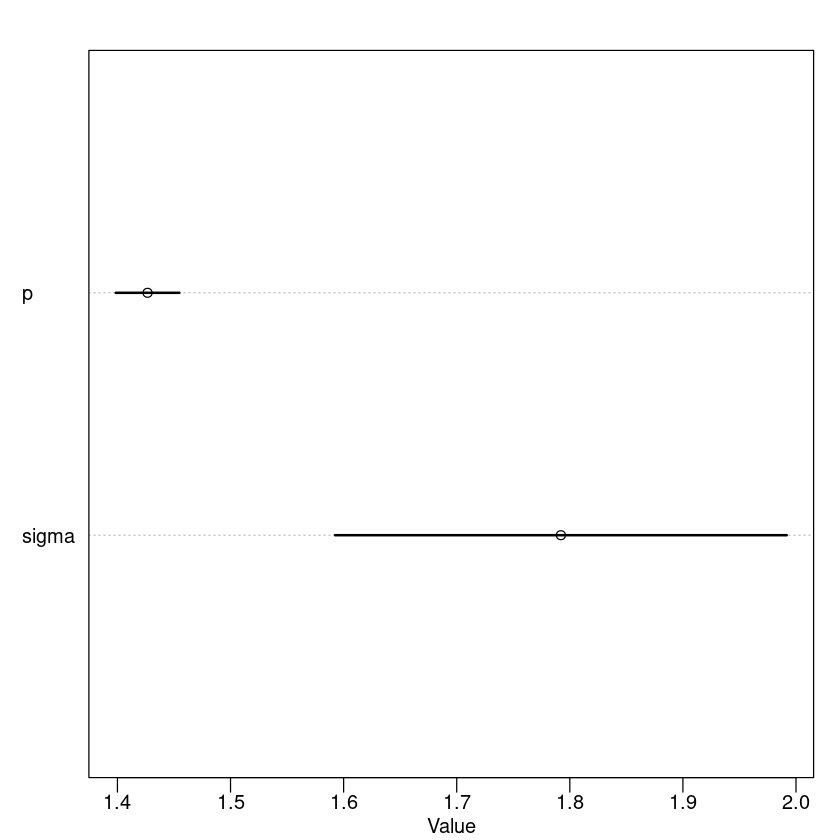

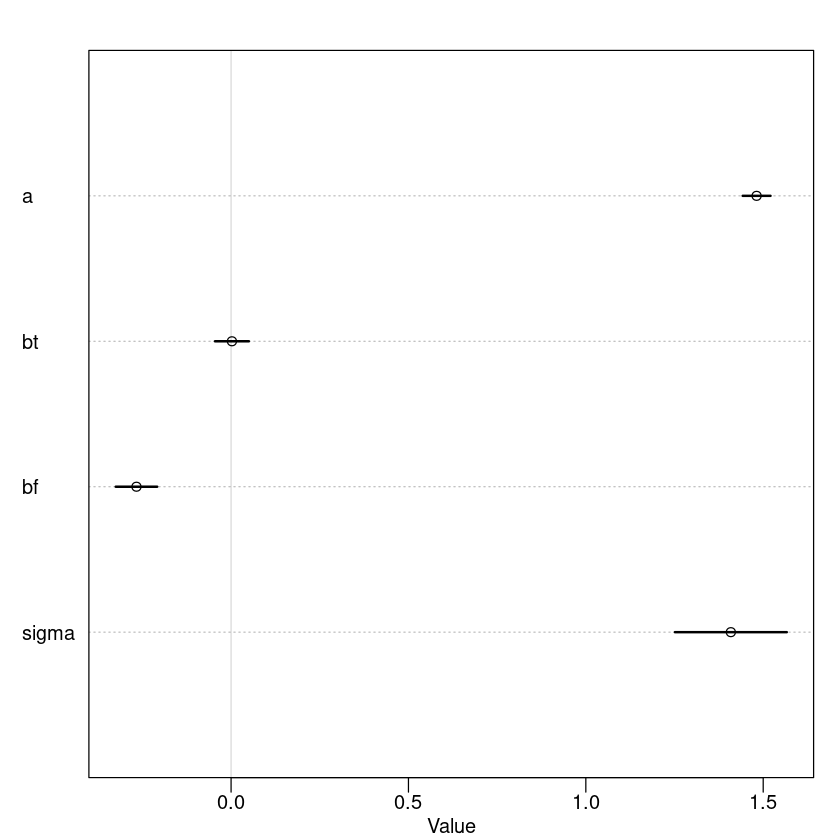

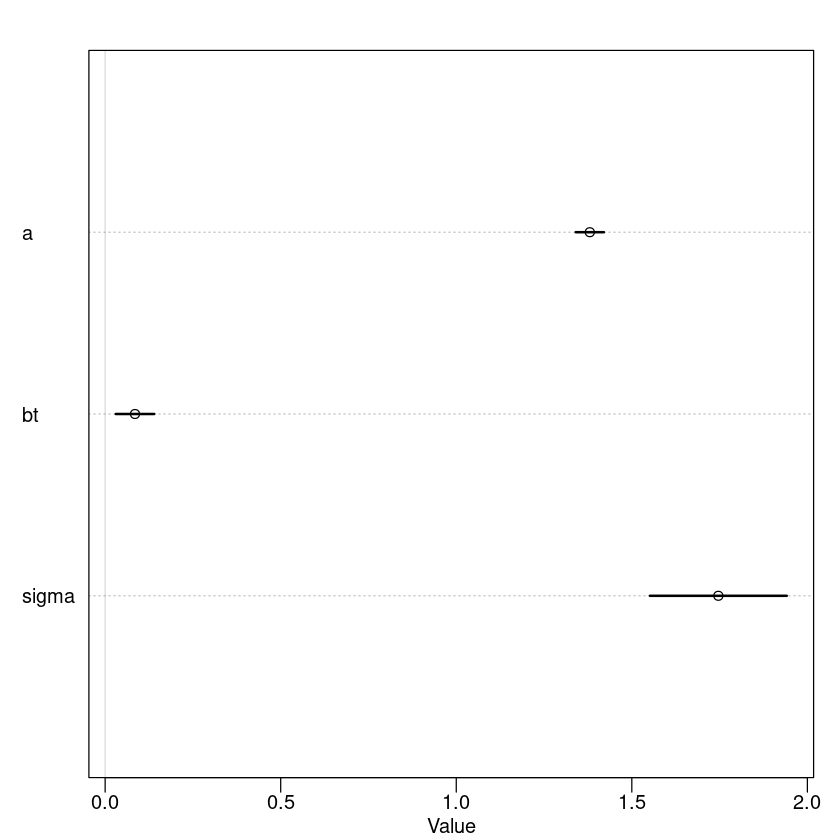

In [27]:

set.seed(71)
N <- 100 # number of plants

# initial heights
h0 <- rnorm(N, 10, 2)

#assign treatments and simulate fungus and growth
treatment <- rep(0:1, each=N/2)
fungus <- rbinom(N, size=1, prob=0.5 - treatment * 0.4)
h1 <- h0 + rnorm(N, 5 - 3 * fungus)

# clean data frame
plant_data <- data.frame(h0=h0, h1=h1, treatment=treatment, fungus=fungus)
m6.6 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p ~ dlnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=plant_data
)
m6.7 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=plant_data
)
m6.8 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=plant_data
)

plot(precis(m6.6))
plot(precis(m6.7))
plot(precis(m6.8))

In [28]:
set.seed(11)
WAIC(m6.7)

WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
361.4511,-177.1724,3.5532,14.17035


The first value is the guess for the out-of-sample deviance. The next one is the lppd, then the effective number of parameters (`penalty`), and the standard error of the WAIC.

There's also a convenience function, `compare`:

In [29]:
compare(m6.6, m6.7, m6.8, func=WAIC)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.7,361.8358,14.19774,0.00000,NA,3.784043,1.000000e+00
m6.8,402.6981,11.19438,40.86224,10.40046,2.608455,1.339301e-09
m6.6,405.9401,11.61637,44.10428,12.22475,1.593155,2.647756e-10


In [30]:
# Basically the same result with PSIS
compare(m6.6, m6.7, m6.8, func=PSIS)

,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.7,361.7536,14.24207,0.00000,NA,3.710445,1.000000e+00
m6.8,403.2932,11.44237,41.53953,10.42531,2.890100,9.545649e-10
m6.6,406.3850,11.83449,44.63132,12.24085,1.804161,2.034383e-10


What are all of the columns?

The first one is the raw WAIC (or whatever) values. Smaller values are better, and the models are ordered by WAIC, smallest to largest. Note that the model that includes the fungus has the lowest WAIC.

`pWAIC` is the penalty term of WAIC. These values are close to, but slightly lower than, the the number of dimensions in the posterior of each model, which is to be expected in linear regressions with regularizing priors.

`dWAIC` is the difference between the model's WAIC and the WAIC of the best model in the comparison. `m6.8` is about 40 units worse than `m6.7` (the best one), and `m6.6` is about 3 units worse than that. Are these big differences? One way to answer that is to ask a different question: are the models easily distinguished by their expected out-of-sample accuracy?

The other two columns, `SE` and `dSE` are there to help us with that. `SE` is the approximate standard error of each model. Very approximately, we expect the uncertainty in our out-of-sample accuracy to be normally distributed with mean equal to the reported WAIC and standard deviation equal to the standard error. When the saple is small, the approximation tends to dramatically underestimate the uncertainty, but it's still better than the AIC, which provides no way to gauge the uncertainty.

To judge whether the models are easy to distinguish, we don't use the standard errors - instead, we use the standard error of the difference. What does that mean? Kist like each WAIC value, each *difference* in WAIC also has a standard error. To compute that, we need the pointwise breakdown in WAIC values.

In [31]:

set.seed(91)
waic_m6.7 <- WAIC(m6.7, pointwise = T)$WAIC
waic_m6.8 <- WAIC(m6.8, pointwise = T)$WAIC
waic_m6.8

[1] 3.982367 6.148053 4.190820 3.240998 3.443360 3.079536 2.973748 3.546291
  [9] 3.370761 3.218914 4.500322 3.027279 3.104188 5.553584 3.573760 5.893312
 [17] 3.732063 2.999573 4.449840 4.829681 3.203478 4.579683 3.975595 3.129387
 [25] 4.258725 4.608880 7.128673 2.995892 4.134243 3.721674 5.057056 3.055009
 [33] 3.078485 2.980377 6.110342 6.936225 3.075126 3.370186 5.593295 3.509527
 [41] 3.345575 5.318041 3.883744 3.014779 3.306376 5.041963 3.002840 3.210314
 [49] 3.650033 4.202001 4.474244 5.721725 6.781794 4.706933 3.689093 5.135913
 [57] 2.982982 5.415777 4.803194 3.077252 6.260799 4.555583 3.001474 4.158778
 [65] 4.261846 4.082433 3.247896 3.340906 4.095850 2.994778 3.011720 3.556132
 [73] 4.495337 3.159279 2.978473 3.872043 3.269619 3.207838 3.504352 3.732497
 [81] 3.484693 3.021519 3.062635 3.138298 3.396484 3.444966 2.974982 3.407763
 [89] 4.163661 3.636118 5.761718 8.047308 3.118757 5.407411 3.424513 4.474740
 [97] 3.073196 6.616877 3.169132 3.256811

In [32]:

n <- length(waic_m6.7)

diff_m6.7_m6.8 <- waic_m6.7 - waic_m6.8
sqrt(n * var( diff_m6.7_m6.8 ))

[1] 10.35785

This is the value in the second row of the `compare` table, with a slight difference due to simulation variance. The difference between the odels is 40.9 and the standard error is about 10.4. If we imagine the 99% (z-score of about 2.6) intervale of the difference, it'll be about

In [33]:
40 + c(-1, 1) * 10.4 * 2.6

[1] 12.96 67.04

So yes, these models are easy to distinguish by expected out-of-sample accuracy. Model `m6.7` is a lot better. We might be able to see this better if we plot the `compare` table:

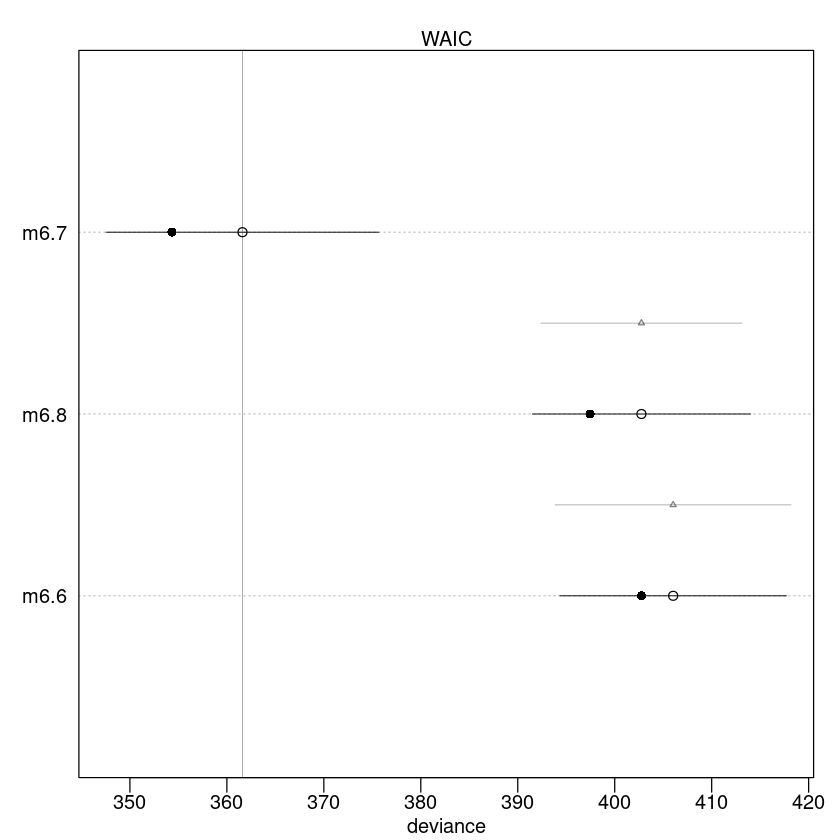

In [34]:
plot(compare(m6.6, m6.7, m6.8))

Filled-in is the in-sample deviance values and the hollow ones are the estimated out-of-sample ones. What we really want is the standard error of the difference in WAIC between the two models - this is the lighter line segment with the triangle on it.

Note: we can't use WAIC to infer causality! We built the model, so we know that `m6.8` is the correct one, not `m6.7` (which is the one that includes the fungus). WAIC did its job - it found the model with the better predictive accuracy.

So now let's ask about the difference between `m6.8` (treatment only) and `m6.6` (intercept only).

WAIC thinks that these models are quite similar - only 3 units of deviance betwen them. Let's calculate the standard error of the difference:

In [35]:
set.seed(92)
waic_m6.6 <- WAIC(m6.6, pointwise=T)$WAIC
diff_m6.6_m6.8 <- waic_m6.6 - waic_m6.8
sqrt(n * var(diff_m6.6_m6.8))

[1] 4.858914

The `compare` table doesn't show this value, but it did calculate it. We just need the `dSE` slot of the return:

In [36]:
set.seed(93)
compare(m6.6, m6.7, m6.8)@dSE

,m6.6,m6.7,m6.8
m6.6,NA,12.20638,4.934353
m6.7,12.206380,NA,10.426576
m6.8,4.934353,10.42658,NA


This contains the pairwise difference standard errors for the models compared. Note: the standard error of the different for `m6.6` and `m6.8` is larger than the actual difference - we can't reliably distinguish between these based on the WAIC.

There's another thing to consider: the `weight` column. This is a way to summarize the relative support for each model. They always sum to 1, within a set of compared models.

$$
w_i = \frac{e^{-\frac{1}{2} \Delta_i}}{\sum_j e^{-\frac{1}{2}\Delta_j}}
$$

Where $\Delta_i$ i sthe difference between model $i$'s WAIC value and the best WAIC value in the set. These are the `dWAIC` values in the table. These can be a quick way to see how big the differences are between models. However, they don't take into account the standard errors - you still need to do that.

They can also be used for **model averaging**. This is a family of methods for combining the predictions of multiple models. It's not covered in this book...

### Outliers and other illusions

In the divorce example from **Chapter 5**, some states were hard for the model to predict. In particular, Idaho was something of an **outlier**. Points like these tend to be very influential in calculating regressions. Let's see how PSIS and WAIC represent that importance.


In [37]:
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce
d$A <- standardize(d$MedianAgeMarriage)
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)

m5.1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

m5.2 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

m5.3 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

In [38]:
set.seed(24071847)
compare(m5.1, m5.2, m5.3, func=PSIS)

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.1,127.5665,14.69485,0.000000,NA,4.671425,0.8340176286
m5.3,130.8062,16.15696,3.239685,1.808671,6.578663,0.1650769863
m5.2,141.2178,11.56557,13.651299,10.923820,4.057204,0.0009053851


A few things to note:

First, `m5.1`, the model that omits the marriage rate, comes out on top. Marriage rate has very little association with the divorce rate, so omitting it has a slightly better expectd out-of-sample performance, even though it actually fits the data slightly worse than `m5.3`, the one that includes both. The difference between the top two models is only 1.8, with a standard error of 0.9 - the models make very similar predictions. This is a typical pattern whenever some predictor has a very small association with the outcome.

There are also some warnings! `Some Pareto k values are very high...`. This means that the smoothing approzimation the PSIS uses is unreliable for some points. Recall from the earlier section that a Pareto $k$ value above 0.5 means that the importance weight can be unreliable. These points tend to be outliers with unlikely values. As a result, they are highly influential and make it difficult to estimate out-of-sample accuracy.

Why is this? Any new sample is unlikely to contain these outliers, and since the outliers have such a large effect on the model, it makes the predictions worse than expected. WAIC is vulnerable to outliers as well - it just doesn't have the automatic warning. It does have a way to measure the risk though - the estimate of the overfitting penalty.

Let's look at the individual states. We can do this by adding the `pointwise=T` parameter to PSIS, resulting in a matrix with each observation on a row and the PSIS information, including the Pareto $k$ values, in columns.

In [39]:
set.seed(24071847)
PSIS_m5.3 <- PSIS(m5.3, pointwise=T)
head(PSIS_m5.3)

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,lppd,penalty,std_err,k
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.296682,-2.1483409,0.13078938,16.92841,0.21966456
2,4.231526,-2.1157631,0.24946268,16.92841,0.39684752
3,1.774601,-0.8873004,0.01091575,16.92841,0.05704868
4,4.802686,-2.4013431,0.31619109,16.92841,0.40599080
5,1.942635,-0.9713177,0.01849122,16.92841,-0.01293164
6,2.922052,-1.4610259,0.06756908,16.92841,0.27888723


In [40]:
WAIC_m5.3 <- WAIC(m5.3, pointwise=T)
head(WAIC_m5.3)

,WAIC,lppd,penalty,std_err
,<dbl>,<dbl>,<dbl>,<dbl>
1,4.218468,-2.0026692,0.10656474,14.35521
2,4.177399,-1.8748883,0.21381110,14.35521
3,1.768440,-0.8737807,0.01043901,14.35521
4,4.709342,-2.0823216,0.27234964,14.35521
5,1.936052,-0.9516979,0.01632804,14.35521
6,2.911897,-1.3953856,0.06056297,14.35521


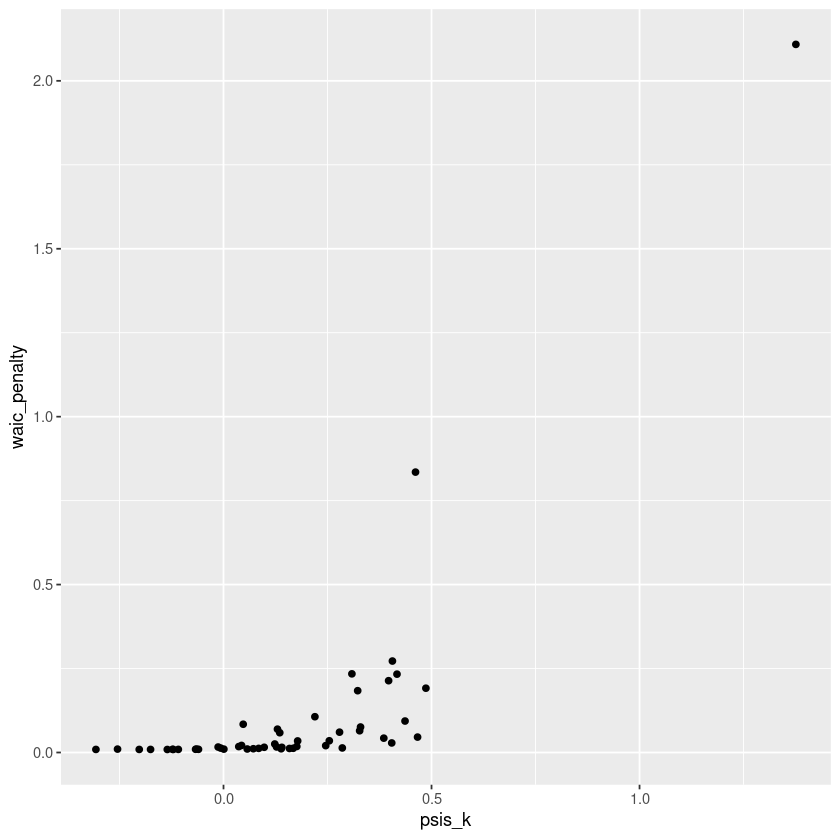

In [41]:
plot_df <- data.frame(psis_k=PSIS_m5.3$k, waic_penalty=WAIC_m5.3$penalty)
ggplot(plot_df, aes(psis_k, waic_penalty)) +
    geom_point()

The point in the top right is Idaho. Note that it is more than twice as large as the point at which the variance becomes theoretically infinte ($k=0.5$). The other outlier point is ME.

Note also that WAIC assigns Idaho a penalty of more than 2. The outlier Idaho is causing additional overfitting risk.

What can we do? There is a tradition of dropping outliers. However, this is a bad idea - a point can only be an outlier in terms of a model. 

A basic problem here is that the Gaussian error model is easily surprised. Gaussian distributions have thin tails - little weight is given to observations far from the mean. Many natural phenomena actually display this. However, others don't! Instead, they have thicker tails witth rare, extreme events. There are not measurement errors, but real events containing information about a natural process.

One way to incorporate outliers without having it affect the results too much is to use a **robust regression**. Generally, this means one where the influence of extreme observations is reduced. One common way to do that is to replace the Gaussian with a **Student's t** distribution. The Student-t distribution arises as a result of a mixture of Gaussian's with different variances.

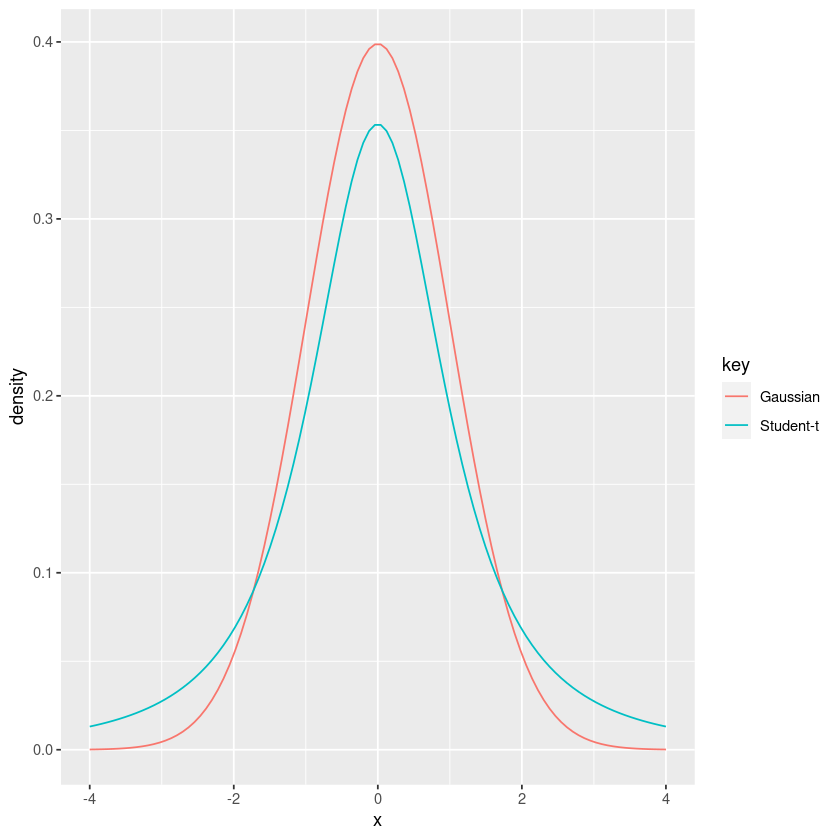

In [42]:
values <- seq(-4, 4, length.out=100)
gaussian_df <- data.frame(x=values, density=dnorm(values, mean=0, sd=1), key="Gaussian")
student_df <- data.frame(x=values, density=dstudent(values, nu=2, mu=0, sigma=1), key="Student-t")
plot_df <- rbind(gaussian_df, student_df)
ggplot(plot_df, aes(x, density)) +
    geom_line(aes(colour=key))

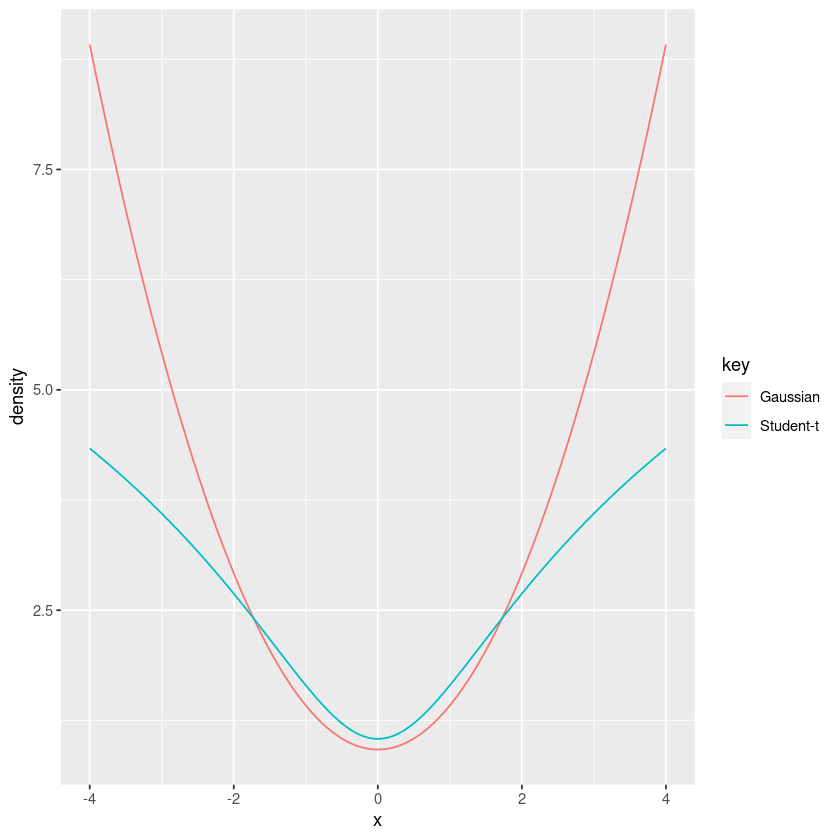

In [43]:
gaussian_df <- data.frame(x=values, density=-log(dnorm(values, mean=0, sd=1)), key="Gaussian")
student_df <- data.frame(x=values, density=-log(dstudent(values, nu=2, mu=0, sigma=1)), key="Student-t")
plot_df <- rbind(gaussian_df, student_df)
ggplot(plot_df, aes(x, density)) +
    geom_line(aes(colour=key))

The Student-t distribution has the same $\mu$ and $\sigma$ parameters as the Gaussian, but also has an extra parameter $\nu$ that controls how thick the tails are. As $\nu \to \infty$, the Student-t converges to the Gaussian.

If you have lots of data, you can estimate $\nu$. However, lots of times you won't have enough to be able to estimate the frequency of rare events. Instead, we assume that $\nu$ is small (thick tails)

Let's see what happens when we estimate our model, but now with a Student-t distribution:

In [44]:
m5.3t <- quap(
    alist(
        D ~ dstudent(2, mu, sigma),
        mu <- a + bM * M + bA * A,
        a ~ dnorm(0, 0.2),
        c(bM, bA) ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

In [45]:
PSIS(m5.3t)

PSIS,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
133.5325,-66.76626,6.745632,11.87595


Note that there are no warnings about Pareto $k$ values! How did this affect the models?

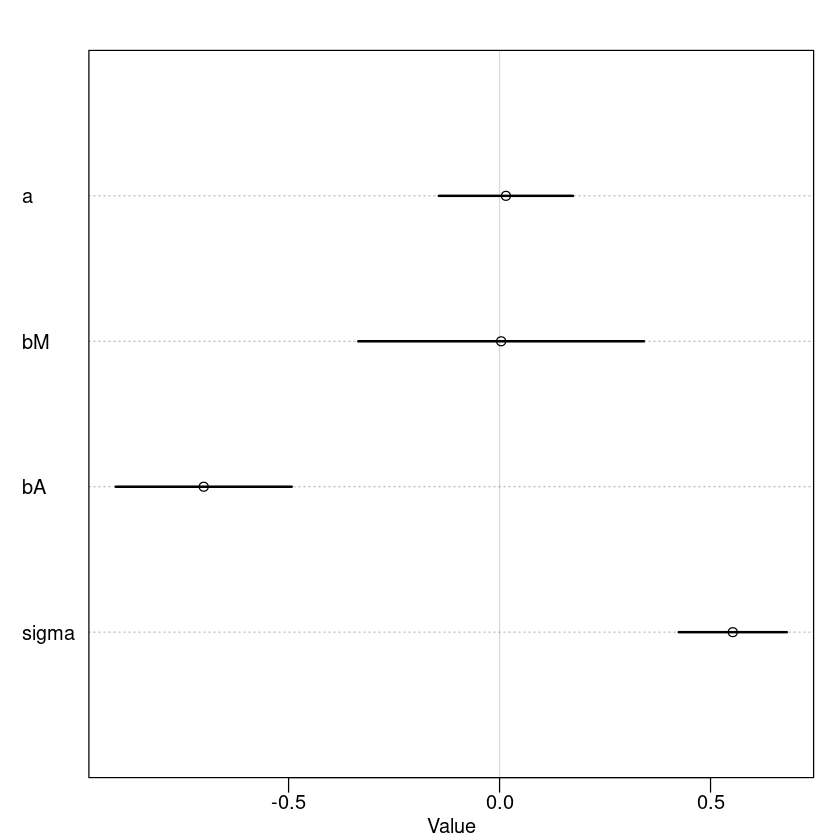

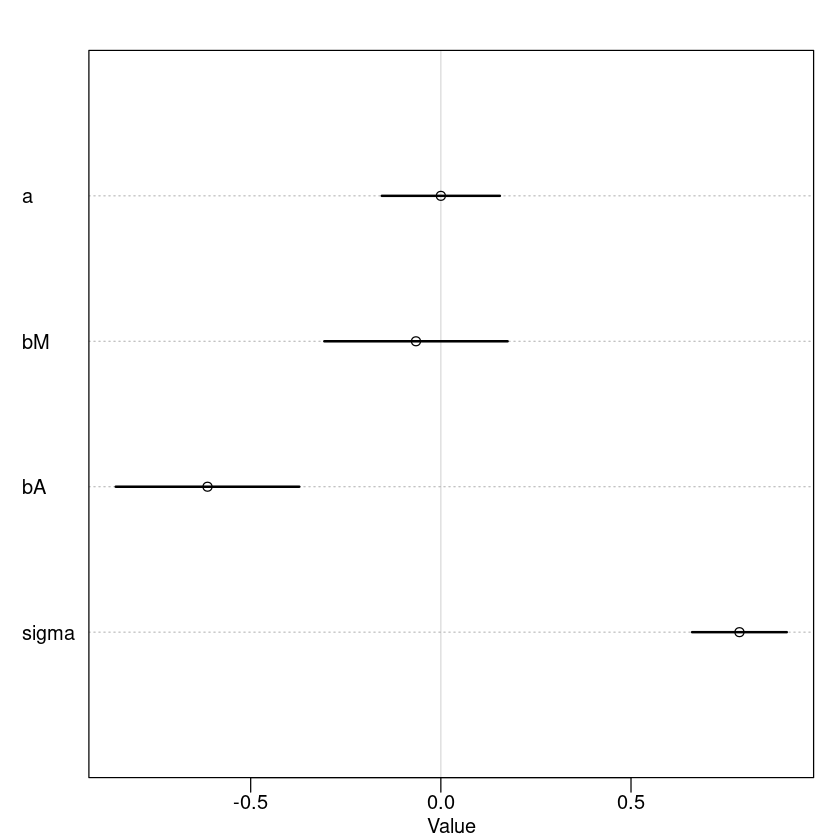

In [46]:
plot(precis(m5.3t))
plot(precis(m5.3))

From the plot, you can see that $bM$ has been slightly increased (closer to 0) in `m5.3t` and $bA$ has gotten farther from 0. This is because Idaho was dragging the value up. By using the Student-t distribution, we reduce its effect.

## Practice

### 7E1
State the three motivating criteria that define information entropy.

1. The measure should be continuous in the different probabilities (no sudden jumps!)
1. In general, should increase as the number of possible events increases (there's more uncertainty)
1. Should be additive over different possibilities. That is, if there is a compound probability, the entropy of that combined event should be the sum of the entropies of the constituents.

### 7E2 
Suppose a coin is weighted such that it lands on heads 70% of the time. What is the entropy of this coin?

In [47]:
H <- function(p) {
    -sum(p * log(p))
}
H(c(0.7, 0.3))

[1] 0.6108643

### 7E3
Suppose a 4-sided die is loaded such that, when tossed, it shows 1 -> 20%, 2 -> 25%, 3 -> 25%, 4 -> 30%. What is the entropy of the dice?

In [48]:
H(c(0.2, 0.25, 0.25, 0.3))

[1] 1.376227

### 7E4
Suppose another 4-sided dice never shows "4", and shows the rest with equal likelihood. What is the entropy?

In [49]:
H(rep(1/3, 3))

[1] 1.098612

### 7M1
Write down and compare the definitions of AIC and WAIC. Which of these is most general? Which assumptions are required to transform the more general criterion into the less general one?

Akaike Information Criterion:
$$
\text{AIC} = D_{\text{train}} + 2p = -2\text{lppd} + 2p
$$
where 
- $D_{\text{train}}$ is the **training deviance** (recall: deviance is $-2 *$ lppd)
- lppd is the **log-pointwise predictive density** - basically the continuous version of $S(q) = \sum_i \log q_i$ (summing over all of the observations $i$)
- $p$ is the number of free parameters in the model

Widely Applicable Information Criterion:
$$
\text{WAIC} = -2 \left( \text{lppd} - \underbrace{\sum_i \text{var}_\theta \log p (y_i | \theta)}_{\text{penalty term}} \right)
$$

The Widely Applicable Information Criterion (WAIC) is more applicable. To transform the more applicable one to the less applicable one, we would need 
1. The priors to be flat (or overwhelmed by the likelihood)
1. The posterior is well-approximated by a multivariate gaussian
1. The sample size $N >> k$, the number of parameters

### 7M2
Explain the difference between *model selection* and *model comparison*. What information is lost under model selection?

Model selection means choosing one model and discarding the rest; model comparison, on the other hand, just means comparing the different models. When you select a model, you are throwing away all of the other information about (e.g.) how close the other models were.

### 7M3
When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values if the models were fit to different numbers of observations? Perform some experiments if you're not sure.

The different models must be fit to the same data because all of the information criteria involve summing over the different observations. If you are summing different models over different observations, then you can no longer compare the numbers that you are getting out at the end.

### 7M4
What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior becomes more concentrated? Performs some experiments if you're not sure.

In [50]:
# let's simulate a linear regression and then concentrate the prior
x <- seq(-3, 3, length.out=10)
y <- 1 * x + 0
y <- y + rnorm(length(y), mean=0, sd=1)
data <- data.frame(
    x=x,
    y=y
)

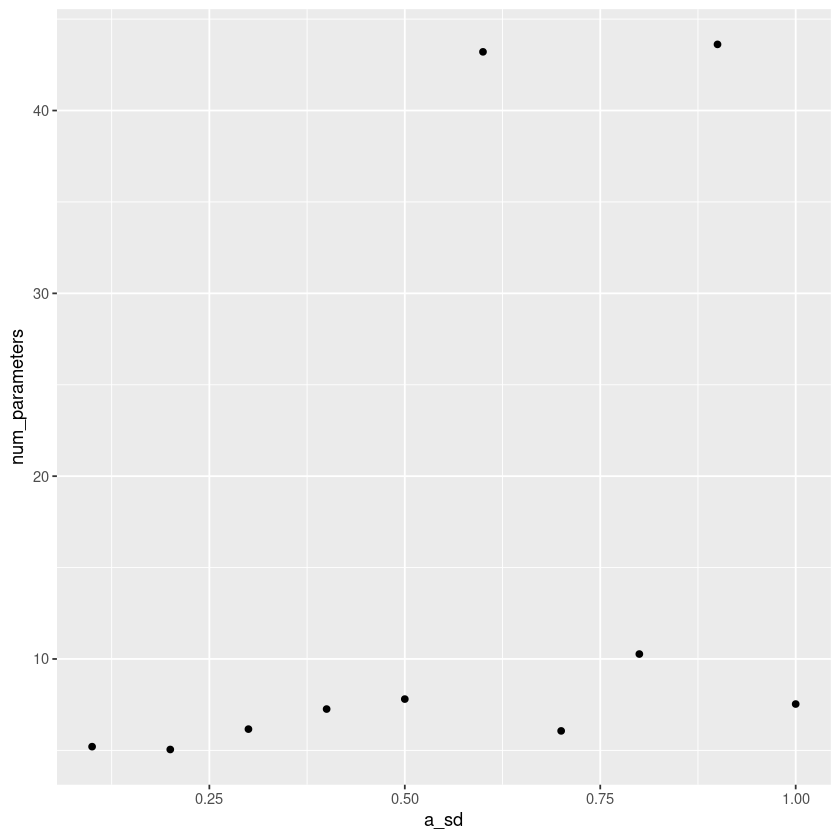

In [51]:

plot_df <- data.frame(a_sd=double(), num_parameters=double())
for (a_sd in seq(0.1, 1, length.out=10)) {
    model <- quap(
        alist(
            y ~ dnorm(mu, sigma),
            mu <- a * x + b,
            a ~ dnorm(1, a_sd),
            b ~ dnorm(0, 1),
            sigma ~ dexp(1)
        ),
        data=data
    )
    penalty <- WAIC(model)$penalty
    plot_df <- rbind(plot_df, data.frame(a_sd=a_sd, num_parameters=penalty))
}
ggplot(plot_df, aes(a_sd, num_parameters)) +
    geom_point()

So it looks like as the prior becomes more concetrated, the effective number of parameters decreases. This makes sense - the model has less 'freedom' than if the priors are more flat.

### 7M5
Provide an informal explanation of why informative priors reduce overfitting.

Overfitting happens when the model "learns too much" from the data - the values of the parameters are too strongly influenced by the actual data. By using informative priors, the weight of the actual data is reduced.

### 7M6
Provide an informal explanation of why overly informative priors result in underfitting.

If the priors are too strong (informative), then the model is not able to learn from the data - the 'weight' of the priors overwhelms the data. This leads to underfitting because the model "learns too little" from the data.

### 7H1
In 2007, the *Wall Street Journal* publised an editorial ("We're number one, alas") with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn (probably by hand) to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actualy produce less tax revenue. Fit a curve to the actual data, found in `data(Laffer)`. Consider models that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a straight-line model to any curved model you like. What do you conclude about the relationship between tax rate and tax revenue?

In [52]:
data(Laffer)
d <- Laffer
head(d)

,tax_rate,tax_revenue
,<dbl>,<dbl>
1,0.07,-0.06
2,8.81,2.45
3,12.84,3.58
4,16.24,2.19
5,19.18,2.46
6,19.29,1.95


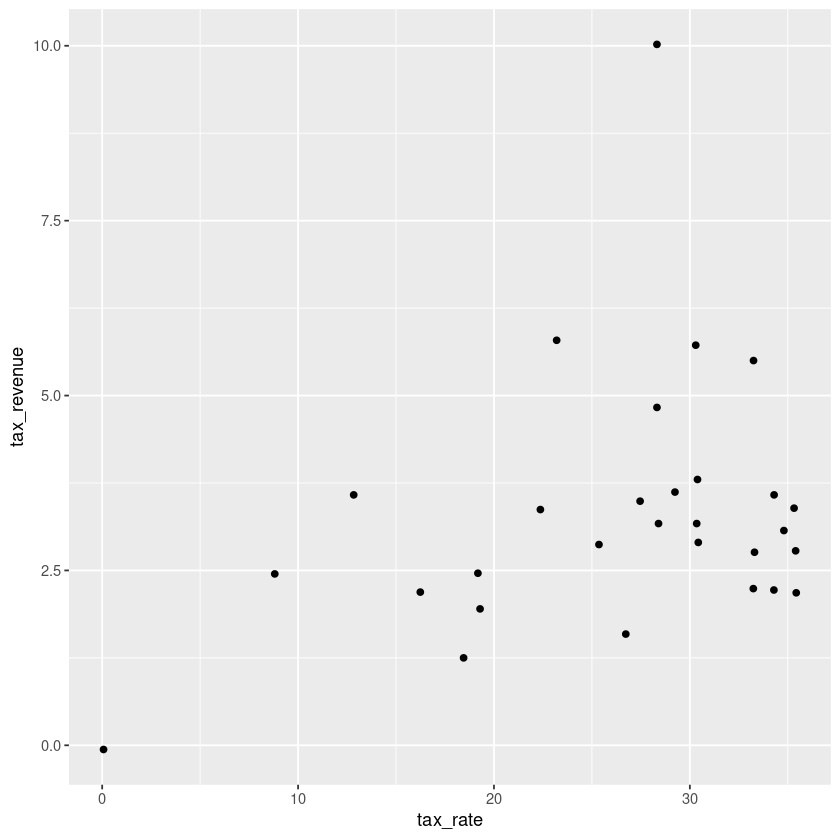

In [53]:
ggplot(d, aes(tax_rate, tax_revenue)) +
    geom_point()

In [54]:
d$T <- standardize(d$tax_revenue)
d$R <- standardize(d$tax_rate)
m7h1_linear <- quap(
    alist(
        T ~ dnorm(mu, sigma),
        mu <- a + b_R * R,
        a ~ dnorm(0, 0.5),
        b_R ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m7h1_quadratic <- quap(
    alist(
        T ~ dnorm(mu, sigma),
        mu <- a + b_R * R + b_R2 * R ^ 2,
        a ~ dnorm(0, 0.5),
        b_R ~ dnorm(0, 0.5),
        b_R2 ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

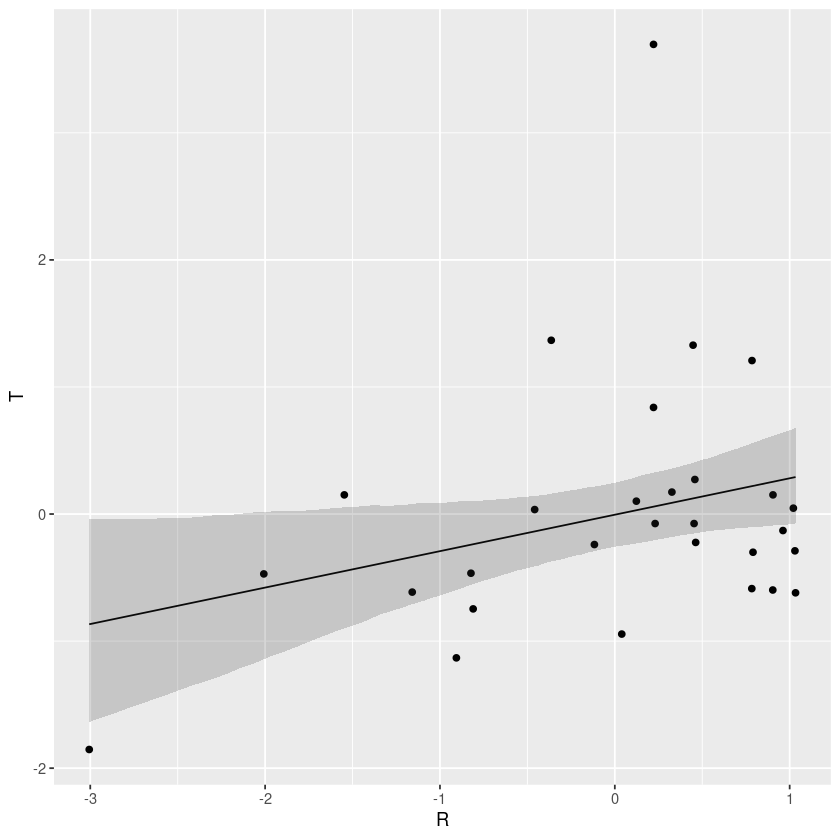

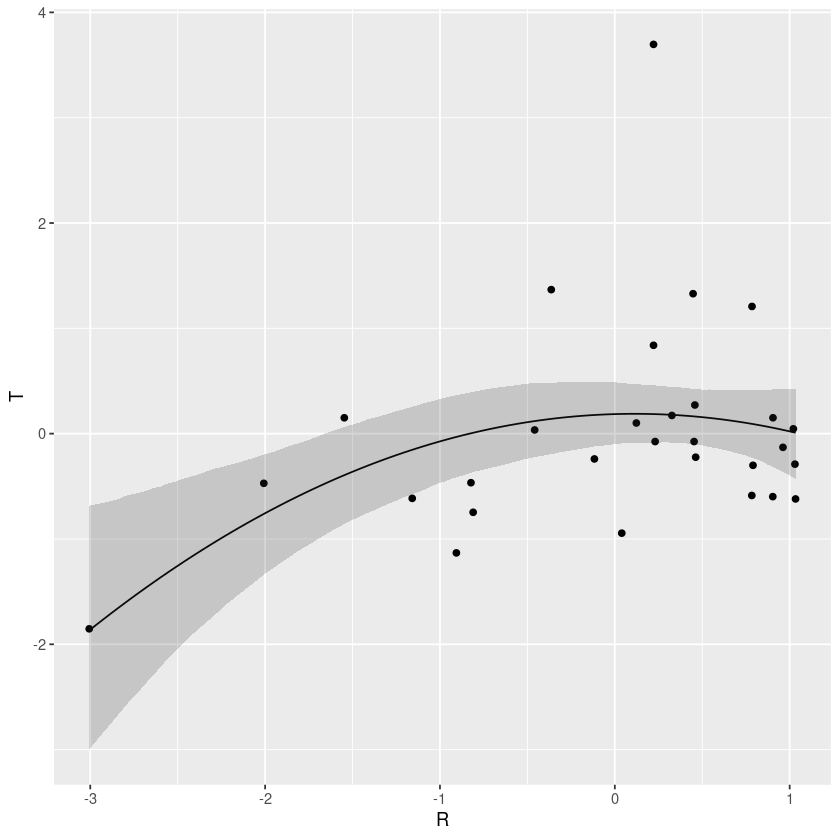

In [55]:
Rs <- seq(min(d$R), max(d$R), length.out=100)
l <- link(m7h1_linear, data=list(R=Rs))
mu <- apply(l, 2, mean)
ci <- apply(l, 2, PI)
plot_df <- data.frame(
    Rs=Rs,
    mean=mu,
    lower=ci[1,],
    upper=ci[2,]
)
ggplot() +
    geom_point(data=d, mapping=aes(R, T)) +
    geom_line(data=plot_df, mapping=aes(Rs, mu)) +
    geom_ribbon(data=plot_df, mapping=aes(x=Rs, ymin=lower, ymax=upper), alpha=0.2)

Rs <- seq(min(d$R), max(d$R), length.out=100)
l <- link(m7h1_quadratic, data=list(R=Rs))
mu <- apply(l, 2, mean)
ci <- apply(l, 2, PI)
plot_df <- data.frame(
    Rs=Rs,
    mean=mu,
    lower=ci[1,],
    upper=ci[2,]
)
ggplot() +
    geom_point(data=d, mapping=aes(R, T)) +
    geom_line(data=plot_df, mapping=aes(Rs, mu)) +
    geom_ribbon(data=plot_df, mapping=aes(x=Rs, ymin=lower, ymax=upper), alpha=0.2)

In [56]:
WAIC(m7h1_linear)
WAIC(m7h1_quadratic)

WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
89.74958,-38.54912,6.325673,22.63719


WAIC,lppd,penalty,std_err
<dbl>,<dbl>,<dbl>,<dbl>
88.19756,-37.326,6.772785,23.36713


In [57]:
compare(m7h1_linear, m7h1_quadratic, func=WAIC)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m7h1_quadratic,90.66911,26.04356,0.00000,NA,8.181801,0.6227836
m7h1_linear,91.67187,24.52922,1.00276,2.554525,7.415004,0.3772164


From this, it seems like both models are basically just as good - the difference in the WAIC is slightly less than one standard error. From this, we should conclude that there isn't strong evidence that the curve trends up or down - both models have approximately the same support.

### 7H2
In the `Laffer` data, there is one country with a high tax revenue that is an outlier. Use PSIS and WAIC to measure the importance of this outlier in the models you fit in the previous problem. Then use robust regression with a Student-t distribution to revisit the curve fitting problem. How much does a curved relationship depend on the outlier point?

In [58]:
psis <- PSIS(m7h1_linear, func=PSIS, pointwise=T)
troublesome_points <- psis[psis$k > 0.5,]
troublesome_points

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



,PSIS,lppd,penalty,std_err,k
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,27.79443,-13.89722,6.211931,25.78748,1.643416


In [59]:

m7h1_linear_robust <- quap(
    alist(
        T ~ dstudent(2, mu, sigma),
        mu <- a + b_R * R,
        a ~ dnorm(0, 0.5),
        b_R ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m7h1_quadratic_robust <- quap(
    alist(
        T ~ dstudent(2, mu, sigma),
        mu <- a + b_R * R + b_R2 * R ^ 2,
        a ~ dnorm(0, 0.5),
        b_R ~ dnorm(0, 0.5),
        b_R2 ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
compare(m7h1_linear_robust, m7h1_quadratic_robust)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m7h1_quadratic_robust,70.79477,14.00644,0.000000,NA,3.926756,0.8515489
m7h1_linear_robust,74.28838,13.62210,3.493603,4.736511,3.725936,0.1484511


Again, the difference in the WAIC scores for each of the models is within one standard error - there still isn't really any strong support for one model over the other.

### 7H3
Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the bird population. They have each found the following proportions of 5 important bird species:

|          | Species A | Species B | Species C | Species D | Species E |
| ---      | ---       | ---       | ---       | ---       | ---       |
| Island 1 | 0.2       | 0.2       | 0.2       | 0.2       | 0.2       |
| Island 2 | 0.8       | 0.1       | 0.05      | 0.025     | 0.025     |
| Island 3 | 0.05      | 0.15      | 0.7       | 0.05      | 0.05      |

There are two parts to this. It isn't computationally tricky, but it is conceptually tricky.

1. Compute the entropy of each island's bird distribution. Interpret these entropy values.
1. Use each island's bird distribution to predict the other two. This means to compute the KL divergence of each island fom the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different KL divergence values. Which island predicts the others best? Why?

In [60]:
island_1 <- c(A=0.2, B=0.2, C=0.2, D=0.2, E=0.2)
island_2 <- c(A=0.8, B=0.1, C=0.05, D=0.025, E=0.025)
island_3 <- c(A=0.05, B=0.15, C=0.7, D=0.05, E=0.05)
H(island_1)
H(island_2)
H(island_3)

[1] 1.609438

[1] 0.7430039

[1] 0.9836003

From this, we can see that the first island has the most entropy, followed by the third and then the second. This has to do with how 'evenly' the probabilities are distributed. The first island has a high entropy because all outcomes are equally likely, while the third has a small concentration with birds C and B and island 2 has most of the weight on birds A and B, with only a bit left over for the rest.

In [65]:
D_KL <- function(p, q) sum(p * log(p / q))
df <- rbind(
    as.data.frame(t(island_1)),
    as.data.frame(t(island_2)),
    as.data.frame(t(island_3))
)
# df$Island <- c("Island 1", "Island 2", "Island 3")
df

A,B,C,D,E
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.20,0.20,0.20,0.200,0.200
0.80,0.10,0.05,0.025,0.025
0.05,0.15,0.70,0.050,0.050


In [68]:
for (i in 1:nrow(df)) {
    for (j in 1:nrow(df)) {
        if (i != j) {
            print(paste("Island", i, "predicting island", j, D_KL(df[i,], df[j,])))
        }
    }
}

[1] "Island 1 predicting island 2 0.970406052783923"
[1] "Island 1 predicting island 3 0.638760437463217"
[1] "Island 2 predicting island 1 0.866433975699932"
[1] "Island 2 predicting island 3 2.01091424147225"
[1] "Island 3 predicting island 1 0.625837612911007"
[1] "Island 3 predicting island 2 1.83884517889091"


For prediction, we want a lower divergence. That means that Island 1, the one where all of the birds are equally present, does the best, with low scores for the other islands. The reason for this is that the predicting the other, unevenly distributed islands with the evenly distributed one results in less 'surprise' than going the other way. You can think of starting on, say, Island 2 as being very sure the most of the birds are going to be of type A, and then being surprised when that's not the case - you get a large divergence. This is akin to using a flat (uninformative) prior when calculating a posterior.

### 7H4
Recall the marriage, age, and happiness collider example from **Chapter 6**. Run models `m6.9` and `m6.10` again. Compare these models using WAIC or PSIS. Which model is expected to make better predictions? Which model provides the correct causal influence about the influence of age on happiness? Can you explain why the answers to these questions disagree?


In [69]:
# setting up the models
d <- sim_happiness(seed=1977, N_years=1000)
d2 <- d[d$age > 17,] # only adults
d2$A <- (d2$age - 18) / (65 - 18)
d2$mid <- d2$married + 1
m6.9 <- quap(
    alist(
        happiness ~ dnorm(mu, sigma),
        mu <- a[mid] + bA * A,
        a[mid] ~ dnorm(0, 1),
        bA ~ dnorm(0, 2),
        sigma ~ dexp(1)
    ),
    data=d2
)
m6.10 <- quap(
    alist(
        happiness ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 1),
        bA ~ dnorm(0, 2),
        sigma ~ dexp(1)
    ),
    data=d2
)

Recall - m6.9 is the one that conditions on the collider (marriage), while 6.10 is the one that (correctly) doesn't do that.

In [72]:
(comparison <- compare(m6.9, m6.10, func=WAIC))

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m6.9,2713.951,37.48632,0.0000,NA,3.724976,1.000000e+00
m6.10,3102.189,27.85411,388.2388,35.29624,2.478987,4.954685e-85


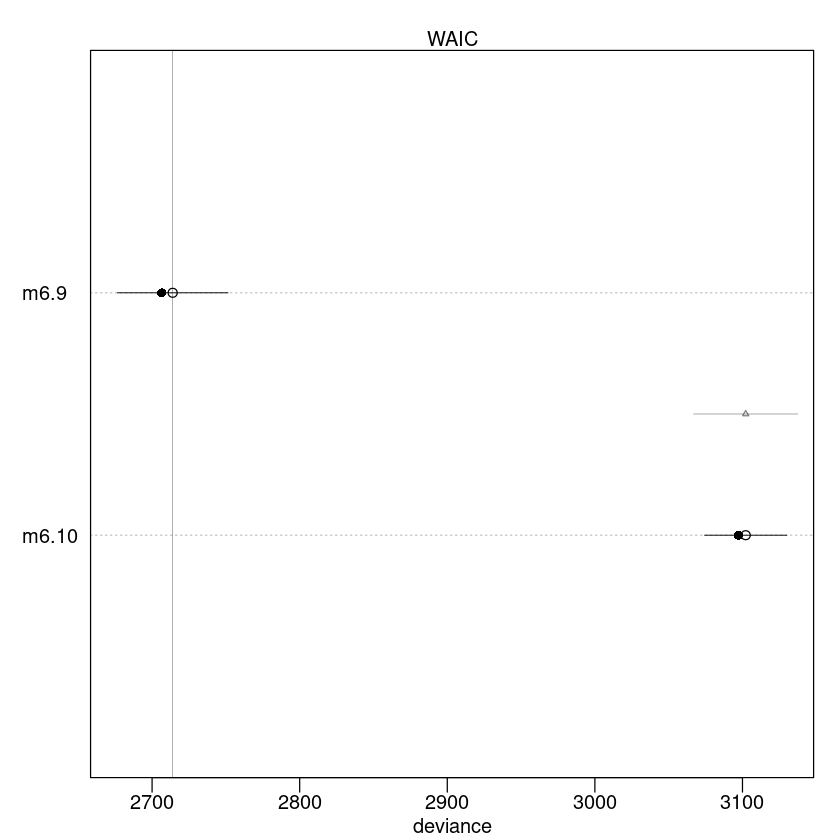

In [73]:
plot(comparison)

In [75]:
# 99% (z=2.6) interval of the difference:
comparison[2, "dWAIC"] + c(-1, 1) * 2.6 * comparison[2, "dSE"]

[1] 296.4686 480.0090

The actual WAIC score is right in this interval, so it's not easy to tell the models apart. That's OK though, because it's not what the question asked.

We expect the model which incorporates the collider (fungus, `m6.9`) to provide slightly better predictions. However, `m6.10`, the one with the collider, is the one that's actually causally correct, which we know because we simulated the data. The reason for this discrepancy is because the collider, marriage status, is closely correlated to marriage and so does provide us with information. Thus, using it in the regression helps us to make better predictions (assuming nothing changes), despite that fact that it is causally incorrect.

### 7H5
Revisit the urban fox data, `data(foxes)`, from the **previous chapter's** practice problems. Use WAIC or PSIS based model comparisons on five different models, each using `weight` as the outcome, and containing these sets of predictor variables.

1. `avgfood` + `groupsize` + `area`
1. `avgfood` + `groupsize`
1. `avgfood` + `area`
1. `avgfood`
1. `area`

Can you explain the relative difference in WAIC scores, using the fox DAG from the **previous chapter**? Be sure to pay attention to the standard error of the score differences (`dSE`)

In [76]:
# setting up the models
data(foxes)
d <- data.frame(
    group=foxes$group,
    AvgFood=standardize(foxes$avgfood),
    GroupSize=standardize(foxes$groupsize),
    Area=standardize(foxes$area),
    Weight=standardize(foxes$weight)
)
m.fox.avgfood.groupsize.area <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bAvgFood * AvgFood + bGroupSize * GroupSize + bArea * Area,
        a ~ dnorm(0, 0.5),
        bAvgFood ~ dnorm(0, 0.5),
        bGroupSize ~ dnorm(0, 0.5),
        bArea ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.fox.avgfood.groupsize <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bAvgFood * AvgFood + bGroupSize * GroupSize,
        a ~ dnorm(0, 0.5),
        bAvgFood ~ dnorm(0, 0.5),
        bGroupSize ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.fox.groupsize.area <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bGroupSize * GroupSize + bArea * Area,
        a ~ dnorm(0, 0.5),
        bGroupSize ~ dnorm(0, 0.5),
        bArea ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.fox.avgfood <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bAvgFood * AvgFood,
        a ~ dnorm(0, 0.5),
        bAvgFood ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
m.fox.area <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bArea * Area,
        a ~ dnorm(0, 0.5),
        bArea ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

In [78]:
(comparison <- compare(m.fox.avgfood.groupsize.area, m.fox.avgfood.groupsize, m.fox.groupsize.area, m.fox.avgfood, m.fox.area, func=WAIC))

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m.fox.avgfood.groupsize.area,323.0847,16.27831,0.0000000,NA,4.781777,0.45074754
m.fox.avgfood.groupsize,323.9037,16.00341,0.8189401,3.507322,3.717190,0.29929728
m.fox.groupsize.area,324.2980,15.78347,1.2133167,2.957211,3.956064,0.24573386
m.fox.avgfood,333.6742,13.84854,10.5894666,7.178958,2.530041,0.00226183
m.fox.area,333.9612,13.80582,10.8764461,7.242307,2.765655,0.00195949


In [79]:
comparison @ dSE

,m.fox.avgfood.groupsize.area,m.fox.avgfood.groupsize,m.fox.groupsize.area,m.fox.avgfood,m.fox.area
m.fox.avgfood.groupsize.area,NA,3.507322,2.957211,7.1789585,7.2423066
m.fox.avgfood.groupsize,3.507322,NA,5.776145,6.5273772,6.7556780
m.fox.groupsize.area,2.957211,5.776145,NA,6.5525907,6.6146053
m.fox.avgfood,7.178958,6.527377,6.552591,NA,0.9498257
m.fox.area,7.242307,6.755678,6.614605,0.9498257,NA


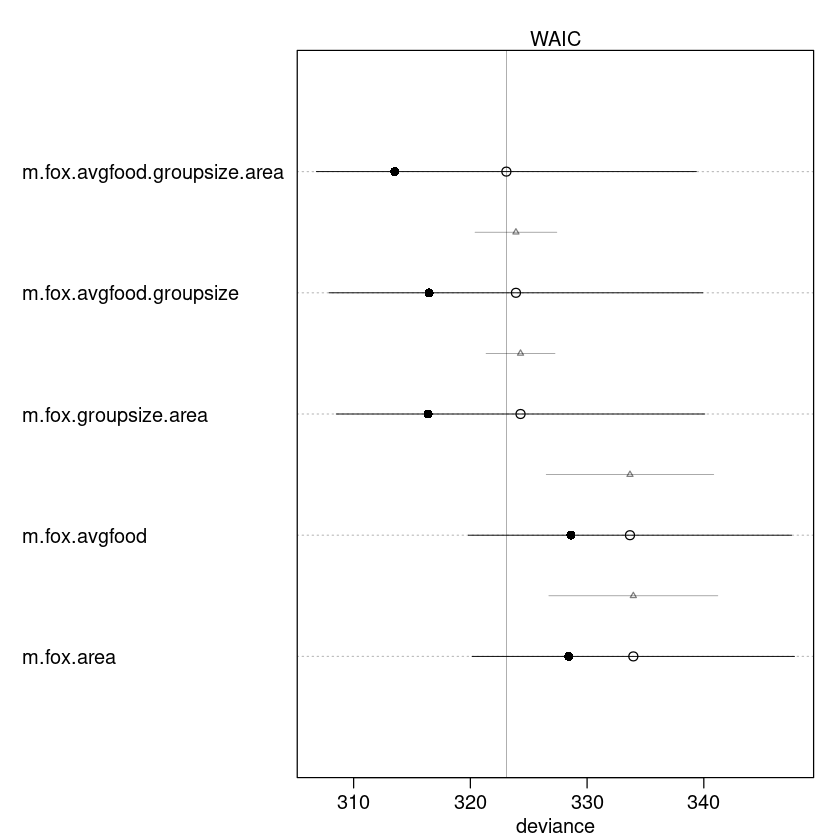

In [82]:
plot(comparison)

So it looks like the models are not that different from each other. However, there seem to be two different classes: the ones that include the groupsize, and the ones that don't. The ones that don't include the groupsize have a higher WAIC (deviance). Looking at the DAG gives us a clue:

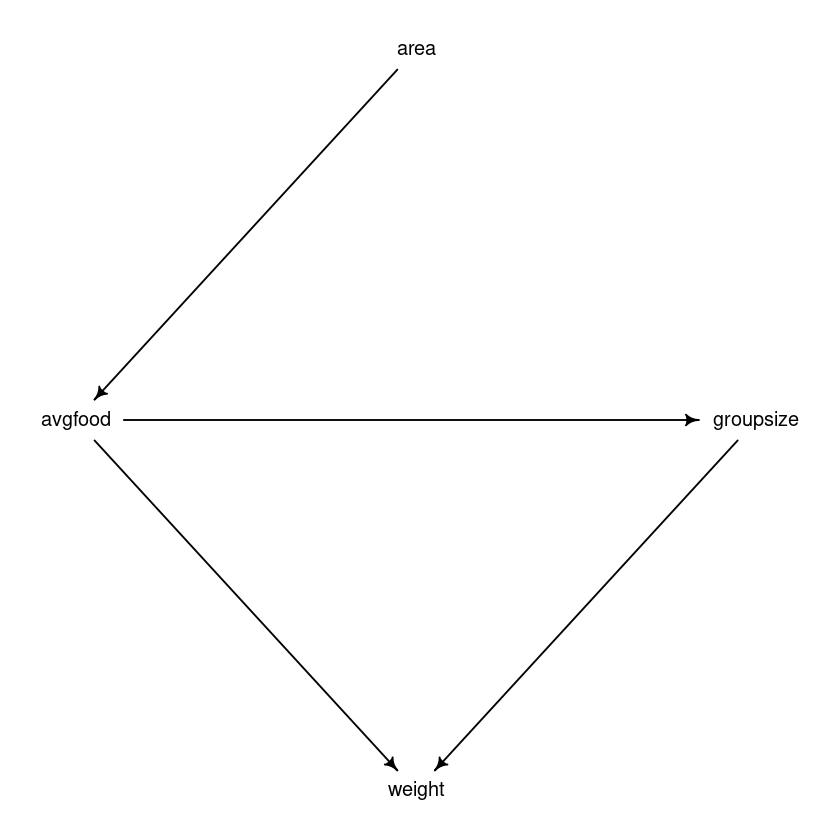

In [81]:

fox_dag <- dagitty('dag{
avgfood[pos="0,0"]
area[pos="1,-1"]
weight[pos="1,1"]
groupsize[pos="2,0"]
area -> avgfood -> groupsize -> weight <- avgfood
}')
drawdag(fox_dag)

From the previous chapter's work, we see that only groupsize has an influence on the weight. Thus, in our case, the models that include it do bettern than the ones that don't. This is a very interesting use of model comparison, because it told us the same thing as our previous work: models with the groupsize do better than those without it, leading us to conclude that the groupsize is the only variable with a significant (causal) impact on the weight.